In [1]:
%who

Interactive namespace is empty.


In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
import matplotlib
import seaborn as sns

# getting the spatial plotting function from another directory
import sys
new_path = '/home/566/ad9701/drought_probability/final_code_AU/'
if new_path not in sys.path:
    sys.path.append(new_path)
import validation_functions as myfuncs
%run -i drought_2017to2019/dataInfo_and_functions.py

import matplotlib.pyplot as plt
import pandas as pd

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
#### NSW also contains data for the period post 2010

# subsetted gauges by basins and saved in csv files. Reading them in  
filename = '/g/data/w97/ad9701/drought_2017to2020/borewell/subset_bores_NSW_post2010_darling.csv'
df_darling = pd.read_csv(filename)

filename = '/g/data/w97/ad9701/drought_2017to2020/borewell/subset_bores_NSW_post2010_Murrum.csv'  #Murrumbidgee & Upper Murray
df_murrum = pd.read_csv(filename)

filename = '/g/data/w97/ad9701/drought_2017to2020/borewell/subset_bores_NSW_post2010_Gwydir.csv'
df_gwydir = pd.read_csv(filename)

filename = '/g/data/w97/ad9701/drought_2017to2020/borewell/subset_bores_NSW_Lachlan.csv'
df_lachlan = pd.read_csv(filename)

filename = '/g/data/w97/ad9701/drought_2017to2020/borewell/subset_bores_NSW_hunter.csv'  #Hunter & Namoi
df_hunter = pd.read_csv(filename)

### Excluded wells QLD

hydroid = 40133180, 40134998, 40147832

Three wells in QLD have partial data covering the first two years of the drought. These wells have been exluded from the calculation of seasonal average deficits to obtain consistent estimates of mean changes in water levels throughout the drought period.
Two of these wells show large water depth anomalies 3-5 m on average.

In [11]:
# Only NSW has relevant data (post 1996)
# QLD has data post 2010

filename = '/g/data/w97/ad9701/drought_2017to2020/borewell/subset_bores_NSW_80perc_post2010_longrec.nc'
ds_gw = xr.open_dataset(filename)
ds_gw.load()
baseline = slice('2010-01-01', None)
vname = 'result'
da_mon = ds_gw[vname].resample(time = '1M').mean()
# subsetting by baseline so that the anomalies calculated for borewells in each region (later used for averaging) are consistent
da_lt_monClim = da_mon.sel(time = baseline).groupby('time.month').mean('time')
da_monAnom = ((da_mon.sel(time = baseline).groupby('time.month') - da_lt_monClim)).assign_attrs({'units': 'm'})

lat_val = np.round(ds_gw['Latitude'].mean(['time', 'obs_point_datum']).values, 3)
lon_val = np.round(ds_gw['Longitude'].mean(['time', 'obs_point_datum']).values, 3)
hydroid = ds_gw.hydroid.values
clim = np.round(da_lt_monClim.mean(['month', 'obs_point_datum']).values, 3)
df_gw_latlon = pd.DataFrame({'lat': lat_val, 'lon': lon_val, 'hydroid': hydroid, 'clim': clim})
#df_gw_latlon.head()

#################################################
# did not get rid of duplicates here because I'm subsetting by non-duplicate hydroids for each basin/reg later
#################################################

# print("How many duplicates are there?")
# print(sum(df_gw_latlon.duplicated(subset=['lat', 'lon', 'clim'])))

# df_latlon_duplicates = df_gw_latlon.groupby(df_gw_latlon[['lat', 'lon', 'clim']].columns.tolist(),as_index=False).size()
# df_latlon_duplicates = df_latlon_duplicates[df_latlon_duplicates['size']>1]
# dup_hydroids = df_gw_latlon.duplicated(subset=['lat', 'lon', 'clim']).values

da_NSW_lt_monClim_post2010 = da_lt_monClim#.isel(hydroid = ~dup_hydroids)
da_NSW_monAnom_post2010 = da_monAnom#.isel(hydroid = ~dup_hydroids)


filename = '/g/data/w97/ad9701/drought_2017to2020/borewell/subset_bores_NSW.nc'
ds_gw = xr.open_dataset(filename)
ds_gw.load()
baseline = slice('1996-01-01', None)
vname = 'result'
da_mon = ds_gw[vname].resample(time = '1M').mean()
# subsetting by baseline so that the anomalies calculated for borewells in each region (later used for averaging) are consistent
da_lt_monClim = da_mon.sel(time = baseline).groupby('time.month').mean('time')
da_monAnom = ((da_mon.sel(time = baseline).groupby('time.month') - da_lt_monClim)).assign_attrs({'units': 'm'})

lat_val = np.round(ds_gw['Latitude'].mean(['time', 'obs_point_datum']).values, 3)
lon_val = np.round(ds_gw['Longitude'].mean(['time', 'obs_point_datum']).values, 3)
hydroid = ds_gw.hydroid.values
clim = np.round(da_lt_monClim.mean(['month', 'obs_point_datum']).values, 3)
df_gw_latlon = pd.DataFrame({'lat': lat_val, 'lon': lon_val, 'hydroid': hydroid, 'clim': clim})
#df_gw_latlon.head()

print("How many duplicates are there?")
print(sum(df_gw_latlon.duplicated(subset=['lat', 'lon', 'clim'])))

df_latlon_duplicates = df_gw_latlon.groupby(df_gw_latlon[['lat', 'lon', 'clim']].columns.tolist(),as_index=False).size()
df_latlon_duplicates = df_latlon_duplicates[df_latlon_duplicates['size']>1]
dup_hydroids = df_gw_latlon.duplicated(subset=['lat', 'lon', 'clim']).values

da_NSW_lt_monClim = da_lt_monClim.isel(hydroid = ~dup_hydroids)
da_NSW_monAnom = da_monAnom.isel(hydroid = ~dup_hydroids)


filename = '/g/data/w97/ad9701/drought_2017to2020/borewell/subset_bores_QLD_80perc_post2010_longrec.nc'
ds_gw = xr.open_dataset(filename)
ds_gw.load()

# QLD: Don't know what is going on with hydroid = 40136254 as WL is steadily decreasing from 2010, so excluding this well
bool_hydroid = ~(ds_gw.hydroid.values == 40136254)
ds_gw = ds_gw.isel(hydroid = bool_hydroid)
baseline = slice('2010-01-01', None)
vname = 'result'
da_mon = ds_gw[vname].resample(time = '1M').mean()
# subsetting by baseline so that the anomalies calculated for borewells in each region (later used for averaging) are consistent
da_lt_monClim = da_mon.sel(time = baseline).groupby('time.month').mean('time')
da_monAnom = ((da_mon.sel(time = baseline).groupby('time.month') - da_lt_monClim)).assign_attrs({'units': 'm'})

inclWells = da_monAnom.count('time').max('obs_point_datum').values >= 36
da_QLD_lt_monClim = da_lt_monClim.isel(hydroid = inclWells)
da_QLD_monAnom = da_monAnom.isel(hydroid = inclWells)

How many duplicates are there?
38


### Line & bar plots of anomalies in smaller sub-regions

In [12]:
import matplotlib
fig_dir = 'figures/drought_2017to2020/borewell/'

data_names = ['Condamine', # (baseline = 201001 to 202109)',
              'Gwydir', # (baseline = 201001 to 202109)',
              'Hunter & Namoi', # (baseline = 201001 to 202109)',
              'Lachlan', # (baseline = 201001 to 202109)',
              'Darling (longer Record)', # (baseline = 199601 to 202109)',
              'Darling', #(baseline = 201001 to 202109)'
              'Murrumbidgee & Upper Murray'] # (baseline = 201001 to 202109)',

time_sel = slice('2016-12-01', '2021-01-01')
              
########
# NSW
########

hydroids_noDTW_NSW = da_NSW_lt_monClim.sel(obs_point_datum = 'DTW').count('month').values == 0

datum_sel = 'DTW'
data_list_NSW = [da_NSW_monAnom.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_NSW_monAnom.hydroid.values[~hydroids_noDTW_NSW]]

# add SWL measurements for wells where the DTW measurements are unavailable
datum_sel = 'SWL'
data_list_swl = [da_NSW_monAnom.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_NSW_monAnom.hydroid.values[hydroids_noDTW_NSW]]
data_list_NSW.extend(data_list_swl)

da_NSW_anom_all = xr.concat(data_list_NSW, dim = 'wells')
da_NSW_anom_mean = da_NSW_anom_all.sel(time = time_sel).mean('wells')

########
# QLD
########

hydroids_noDTW_QLD = da_QLD_lt_monClim.sel(obs_point_datum = 'DTW').count('month').values == 0

datum_sel = 'DTW'
data_list_QLD = [da_QLD_monAnom.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_QLD_monAnom.hydroid.values[~hydroids_noDTW_QLD]]

# add SWL measurements for wells where the DTW measurements are unavailable
datum_sel = 'SWL'
data_list_swl = [da_QLD_monAnom.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_QLD_monAnom.hydroid.values[hydroids_noDTW_QLD]]
data_list_QLD.extend(data_list_swl)

da_QLD_anom_all = xr.concat(data_list_QLD, dim = 'wells')
da_QLD_anom_mean = da_QLD_anom_all.sel(time = time_sel).mean('wells')


####################
# NSW post 2010
####################

list_point_subsets = [df_gwydir['hydroid'].values, df_hunter['hydroid'].values, df_lachlan['hydroid'].values, 
                      df_darling['hydroid'].values, df_murrum['hydroid'].values]
list_anom_mean = []
for point_set in list_point_subsets:
    hydroids_noDTW = da_NSW_lt_monClim_post2010.sel(hydroid = point_set, obs_point_datum = 'DTW').count('month').values == 0

    datum_sel = 'DTW'
    data_list = [da_NSW_monAnom_post2010.sel(hydroid = s, obs_point_datum = datum_sel) for s in point_set[~hydroids_noDTW]]
    # add SWL measurements for wells where the DTW measurements are unavailable
    datum_sel = 'SWL'
    data_list_swl = [da_NSW_monAnom_post2010.sel(hydroid = s, obs_point_datum = datum_sel) for s in point_set[~hydroids_noDTW]]
    data_list.extend(data_list_swl)
    da_reg_anom_all = xr.concat(data_list, dim = 'wells')
    da_reg_anom_mean = da_reg_anom_all.sel(time = time_sel).mean('wells')
    list_anom_mean.append(da_reg_anom_mean)
    
import seaborn as sns
nBasins = len(list_point_subsets)+2
col_sel = sns.color_palette("icefire", nBasins)

list_for_plot = [da_QLD_anom_mean]
list_for_plot.extend(list_anom_mean[0:-2])  # All regions except Darling short record, Murrumbidgee
list_for_plot.extend([da_NSW_anom_mean])    # Darling long record
list_for_plot.extend(list_anom_mean[-2::])    # Darling short record & Murrumbidgee

In [30]:
col_sel[2] = 'green'
col_sel

[(0.37523981, 0.67057537, 0.80420832),
 (0.25423116, 0.40433127, 0.78155831),
 'green',
 (0.12284806, 0.1179729, 0.11772022),
 (0.36178937, 0.1589124, 0.20807639),
 (0.72401436, 0.20691287, 0.25027366),
 (0.93073701, 0.49341219, 0.25065486)]

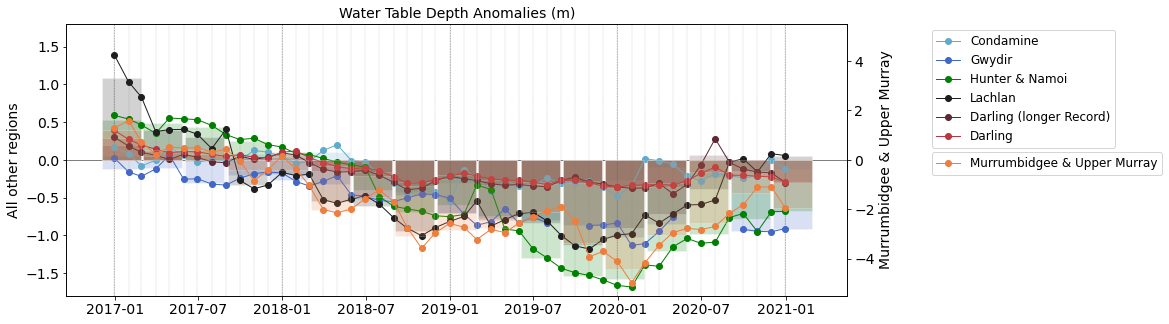

In [31]:
#######
# PLOT
#######

# col_NSW = 'blue'
# col_QLD = 'darkorange'

# list_anom_mean_all = 

fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(14,5)) #width, height

seas_breaks = pd.date_range('2016-12-31', freq='M', periods=12*4+1).to_numpy()#.astype(float)
year_breaks = pd.date_range('2016-12-31', freq='Y', periods=5).to_numpy()

for xline in seas_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)
# # for da, color in zip(data_list, col_sel):
# for da in data_list_NSW:
#     plt.plot(da.time.values - np.timedelta64(20, 'D'), da.values, marker='o', color=col_NSW, label=None, linewidth=0, markersize=1.5, zorder=10)
    
# for da in data_list_QLD:
#     plt.plot(da.time.values - np.timedelta64(10, 'D'), da.values, marker='^', color=col_QLD, label=None, linewidth=0, markersize=2, zorder=10) #, edgecolors='black')

for data, col, label in zip(list_for_plot, col_sel, data_names):
    if label == 'Murrumbidgee & Upper Murray':
        ax2 = ax.twinx()
        ax_sel = ax2
    else:
        ax_sel = ax
        
    ax_sel.plot(data.time.values, data.values*-1, marker='o', color=col, linewidth=1, zorder=10, label = label)
    xx = data.resample(time="QS-DEC").mean().time.values + np.timedelta64(45, 'D')
    array_time = [x.astype('datetime64[D]') for x in xx]
    array_val = data.resample(time="QS-DEC").mean().values*-1
    ax_sel.bar(array_time, array_val, width=85, edgecolor='white', color=col, alpha=0.2, zorder=5) #, label = label)
    #ax_sel.bar(array_time, array_val, width=85, edgecolor=col, zorder=5, fill=False)

# plt.plot(da_NSW_anom_mean.time.values, da_NSW_anom_mean.values, marker='o', color=col_NSW, label=None, linewidth=1, zorder=10)
# plt.plot(da_QLD_anom_mean.time.values, da_QLD_anom_mean.values, marker='o', color=col_QLD, label=None, linewidth=1, zorder=10) #, edgecolors='black')

# xx = da_NSW_anom_mean.resample(time="QS-DEC").mean().time.values + np.timedelta64(45, 'D')
# array_time = [x.astype('datetime64[D]') for x in xx]
# array_val_NSW = da_NSW_anom_mean.resample(time="QS-DEC").mean().values
# plt.bar(array_time[0:-1], array_val_NSW[0:-1], width=85, edgecolor='white', color=col_NSW, alpha=0.2, zorder=5, label = 'southwest NSW')

# xx = da_QLD_anom_mean.resample(time="QS-DEC").mean().time.values + np.timedelta64(45, 'D')
# array_time = [x.astype('datetime64[D]') for x in xx]
# array_val_QLD = da_QLD_anom_mean.resample(time="QS-DEC").mean().values
# plt.bar(array_time[0:-1], array_val_QLD[0:-1], width=85, edgecolor='white', color=col_QLD, alpha=0.35, zorder=5, label = 'southeast QLD')

#bp = plt.boxplot(da_anom_all.values, positions=matplotlib.dates.date2num(da_anom_all.time.values), sym='.', widths=0.12, patch_artist=True) #, notch = True)
#myfuncs.set_box_color(bp, 'blue')

plt.xlabel('')
ax.set_title('Water Table Depth Anomalies (m)')
ax.set_ylabel('All other regions')
ax2.set_ylabel('Murrumbidgee & Upper Murray')
# plt.title(ref_title)
ax.set_ylim((-1.8, 1.8))
ax2.set_ylim((-5.5, 5.5))
ax2.legend(loc="upper left", bbox_to_anchor=(1.1,0.55))
ax.legend(loc="upper left", bbox_to_anchor=(1.1,1))
fig.savefig(fig_dir + 'AllBasin_water_level_anom_from_mon_and_seas_avgLine.png', bbox_inches='tight', dpi = 600)
fig.savefig(fig_dir + 'AllBasin_water_level_anom_from_mon_and_seas_avgLine.pdf', bbox_inches='tight', format = 'pdf')

### Plot of anomalies from 2010 to 2021

In [20]:
import matplotlib
fig_dir = 'figures/drought_2017to2020/borewell/'

data_names = ['Condamine', # (baseline = 201001 to 202109)',
              'Gwydir', # (baseline = 201001 to 202109)',
              'Hunter & Namoi', # (baseline = 201001 to 202109)',
              'Lachlan', # (baseline = 201001 to 202109)',
              'Murrumbidgee & Murray', # (baseline = 201001 to 202109)',
              'Darling (longer Record)', # (baseline = 199601 to 202109)',
              'Darling'] #(baseline = 201001 to 202109)']

time_sel = slice('2010-01-01', None)
    
########
# NSW
########

hydroids_noDTW_NSW = da_NSW_lt_monClim.sel(obs_point_datum = 'DTW').count('month').values == 0

datum_sel = 'DTW'
data_list_NSW = [da_NSW_monAnom.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_NSW_monAnom.hydroid.values[~hydroids_noDTW_NSW]]

# add SWL measurements for wells where the DTW measurements are unavailable
datum_sel = 'SWL'
data_list_swl = [da_NSW_monAnom.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_NSW_monAnom.hydroid.values[hydroids_noDTW_NSW]]
data_list_NSW.extend(data_list_swl)

da_NSW_anom_all = xr.concat(data_list_NSW, dim = 'wells')
da_NSW_anom_mean = da_NSW_anom_all.sel(time = time_sel).mean('wells')

########
# QLD
########

hydroids_noDTW_QLD = da_QLD_lt_monClim.sel(obs_point_datum = 'DTW').count('month').values == 0

datum_sel = 'DTW'
data_list_QLD = [da_QLD_monAnom.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_QLD_monAnom.hydroid.values[~hydroids_noDTW_QLD]]

# add SWL measurements for wells where the DTW measurements are unavailable
datum_sel = 'SWL'
data_list_swl = [da_QLD_monAnom.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_QLD_monAnom.hydroid.values[hydroids_noDTW_QLD]]
data_list_QLD.extend(data_list_swl)

da_QLD_anom_all = xr.concat(data_list_QLD, dim = 'wells')
da_QLD_anom_mean = da_QLD_anom_all.sel(time = time_sel).mean('wells')


####################
# NSW post 2010
####################

list_point_subsets = [df_gwydir['hydroid'].values, df_hunter['hydroid'].values, df_lachlan['hydroid'].values, 
                      df_murrum['hydroid'].values, df_darling['hydroid'].values]
list_anom_mean = []
for point_set in list_point_subsets:
    hydroids_noDTW = da_NSW_lt_monClim_post2010.sel(hydroid = point_set, obs_point_datum = 'DTW').count('month').values == 0

    datum_sel = 'DTW'
    data_list = [da_NSW_monAnom_post2010.sel(hydroid = s, obs_point_datum = datum_sel) for s in point_set[~hydroids_noDTW]]
    # add SWL measurements for wells where the DTW measurements are unavailable
    datum_sel = 'SWL'
    data_list_swl = [da_NSW_monAnom_post2010.sel(hydroid = s, obs_point_datum = datum_sel) for s in point_set[~hydroids_noDTW]]
    data_list.extend(data_list_swl)
    da_reg_anom_all = xr.concat(data_list, dim = 'wells')
    da_reg_anom_mean = da_reg_anom_all.sel(time = time_sel).mean('wells')
    list_anom_mean.append(da_reg_anom_mean)
    
import seaborn as sns
nBasins = len(list_point_subsets)+2
col_sel = sns.color_palette("icefire", nBasins)

list_for_plot = [da_QLD_anom_mean]
list_for_plot.extend(list_anom_mean)
list_for_plot.extend([da_NSW_anom_mean])

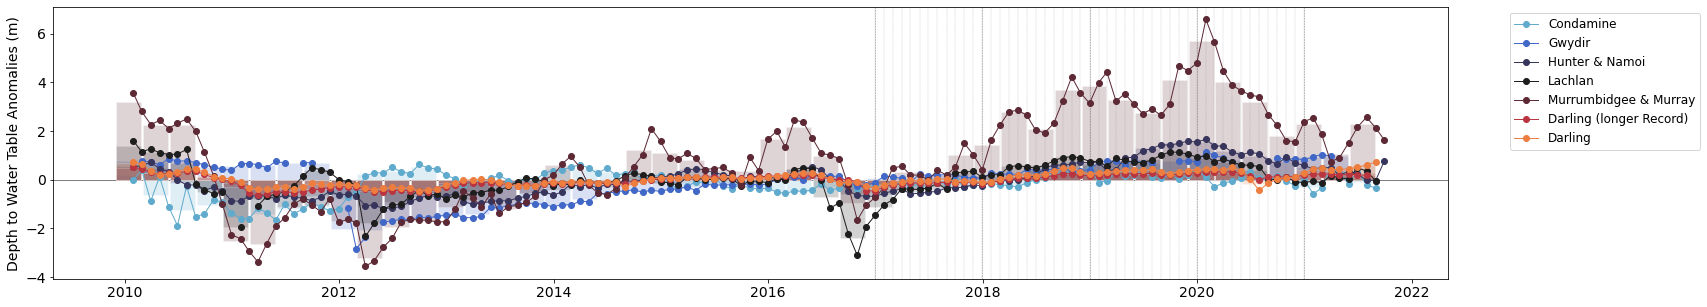

In [22]:
#######
# PLOT
#######

# col_NSW = 'blue'
# col_QLD = 'darkorange'

# list_anom_mean_all = 

fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(25,5)) #width, height

seas_breaks = pd.date_range('2016-12-31', freq='M', periods=12*4+1).to_numpy()#.astype(float)
year_breaks = pd.date_range('2016-12-31', freq='Y', periods=5).to_numpy()

for xline in seas_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)
# # for da, color in zip(data_list, col_sel):
# for da in data_list_NSW:
#     plt.plot(da.time.values - np.timedelta64(20, 'D'), da.values, marker='o', color=col_NSW, label=None, linewidth=0, markersize=1.5, zorder=10)
    
# for da in data_list_QLD:
#     plt.plot(da.time.values - np.timedelta64(10, 'D'), da.values, marker='^', color=col_QLD, label=None, linewidth=0, markersize=2, zorder=10) #, edgecolors='black')

for data, col, label in zip(list_for_plot, col_sel, data_names):
    plt.plot(data.time.values, data.values, marker='o', color=col, linewidth=1, zorder=10, label = label)
    xx = data.resample(time="QS-DEC").mean().time.values + np.timedelta64(45, 'D')
    array_time = [x.astype('datetime64[D]') for x in xx]
    array_val = data.resample(time="QS-DEC").mean().values
    plt.bar(array_time[0:-1], array_val[0:-1], width=85, edgecolor='white', color=col, alpha=0.2, zorder=5) #, label = label)

# plt.plot(da_NSW_anom_mean.time.values, da_NSW_anom_mean.values, marker='o', color=col_NSW, label=None, linewidth=1, zorder=10)
# plt.plot(da_QLD_anom_mean.time.values, da_QLD_anom_mean.values, marker='o', color=col_QLD, label=None, linewidth=1, zorder=10) #, edgecolors='black')

# xx = da_NSW_anom_mean.resample(time="QS-DEC").mean().time.values + np.timedelta64(45, 'D')
# array_time = [x.astype('datetime64[D]') for x in xx]
# array_val_NSW = da_NSW_anom_mean.resample(time="QS-DEC").mean().values
# plt.bar(array_time[0:-1], array_val_NSW[0:-1], width=85, edgecolor='white', color=col_NSW, alpha=0.2, zorder=5, label = 'southwest NSW')

# xx = da_QLD_anom_mean.resample(time="QS-DEC").mean().time.values + np.timedelta64(45, 'D')
# array_time = [x.astype('datetime64[D]') for x in xx]
# array_val_QLD = da_QLD_anom_mean.resample(time="QS-DEC").mean().values
# plt.bar(array_time[0:-1], array_val_QLD[0:-1], width=85, edgecolor='white', color=col_QLD, alpha=0.35, zorder=5, label = 'southeast QLD')

#bp = plt.boxplot(da_anom_all.values, positions=matplotlib.dates.date2num(da_anom_all.time.values), sym='.', widths=0.12, patch_artist=True) #, notch = True)
#myfuncs.set_box_color(bp, 'blue')

plt.xlabel('')
plt.ylabel('Depth to Water Table Anomalies (m)')
# plt.title(ref_title)
#plt.ylim((-1, 1))
plt.legend(loc="upper left", bbox_to_anchor=(1.04,1))
fig.savefig(fig_dir + 'AllBasin_water_level_anom_from_mon_and_seas_avgLine_post2010.png', bbox_inches='tight', dpi = 600)
fig.savefig(fig_dir + 'AllBasin_water_level_anom_from_mon_and_seas_avgLine_post2010.pdf', bbox_inches='tight', format = 'pdf')

### Scratch Space

In [14]:
# baseline = slice('1996-01-01', None)
# fig_suffix = 'ref_post199601'
# ref_title = 'baseline = 199601-202109'

baseline = slice('2010-01-01', None)
fig_suffix = 'ref_post201001'
ref_title = 'baseline = 201001-202109'

# the timeslice of interest for monthly data
time_slice = slice('2016-12-01', '2020-12-31')
vname = 'result'

da_mon = ds_gw[vname].resample(time = '1M').mean()

# the monthly climatology from long-term data
# the monthly anomalies during the drought period
# da_lt_monClim = da_mon.sel(time = baseline).groupby('time.month').mean('time')
# da_monAnom = ((da_mon.sel(time = time_slice).groupby('time.month') - da_lt_monClim)).assign_attrs({'units': 'm'})

# subsetting by baseline so that the anomalies calculated for borewells in each region (later used for averaging) are consistent
da_lt_monClim = da_mon.sel(time = baseline).groupby('time.month').mean('time')
da_monAnom = ((da_mon.sel(time = baseline).groupby('time.month') - da_lt_monClim)).assign_attrs({'units': 'm'})

In [25]:
da_monAnom.obs_point_datum

<xarray.DataArray 'obs_point_datum' (obs_point_datum: 3)>
array(['DTW', 'RSWL (mAHD)', 'SWL'], dtype=object)
Coordinates:
  * obs_point_datum  (obs_point_datum) object 'DTW' 'RSWL (mAHD)' 'SWL'

### QLD excluded wells

In [5]:
inclWells = da_monAnom.count('time').max('obs_point_datum').values >= 36
da_lt_monClim = da_lt_monClim.isel(hydroid = inclWells)
da_monAnom = da_monAnom.isel(hydroid = inclWells)

In [6]:
da_QLD_lt_monClim = da_lt_monClim
da_QLD_monAnom = da_monAnom

### Some data in NSW are duplicates, Identify and exclude them

In [15]:
lat_val = np.round(ds_gw['Latitude'].mean(['time', 'obs_point_datum']).values, 3)
lon_val = np.round(ds_gw['Longitude'].mean(['time', 'obs_point_datum']).values, 3)
hydroid = ds_gw.hydroid.values
clim = np.round(da_lt_monClim.mean(['month', 'obs_point_datum']).values, 3)
df_gw_latlon = pd.DataFrame({'lat': lat_val, 'lon': lon_val, 'hydroid': hydroid, 'clim': clim})
#df_gw_latlon.head()

print("How many duplicates are there?")
print(sum(df_gw_latlon.duplicated(subset=['lat', 'lon', 'clim'])))

df_latlon_duplicates = df_gw_latlon.groupby(df_gw_latlon[['lat', 'lon', 'clim']].columns.tolist(),as_index=False).size()
df_latlon_duplicates = df_latlon_duplicates[df_latlon_duplicates['size']>1]

How many duplicates are there?
183


In [16]:
dup_hydroids = df_gw_latlon.duplicated(subset=['lat', 'lon', 'clim']).values

### Plots to show that this data actually are duplicates

/local/zv2/ad9701/tmp/ipykernel_3458370/3879514931.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,5)) #width, height


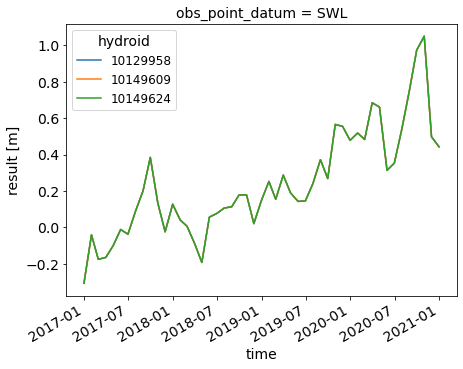

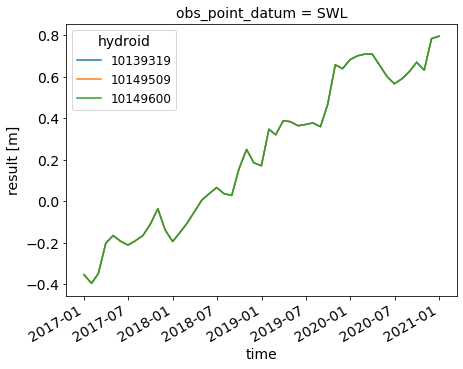

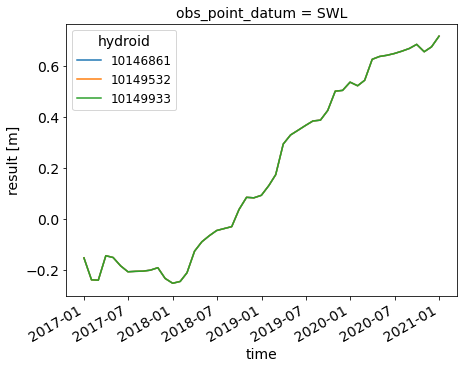

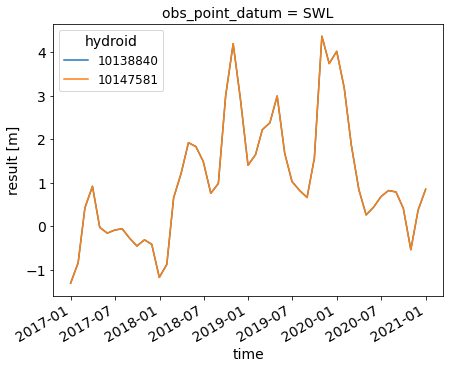

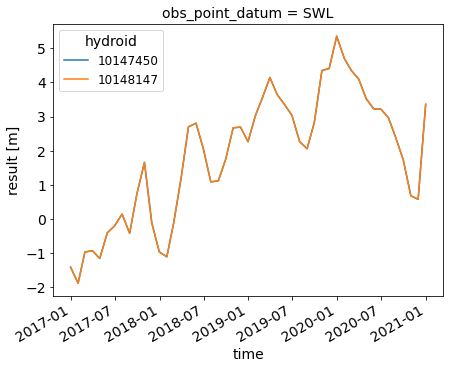

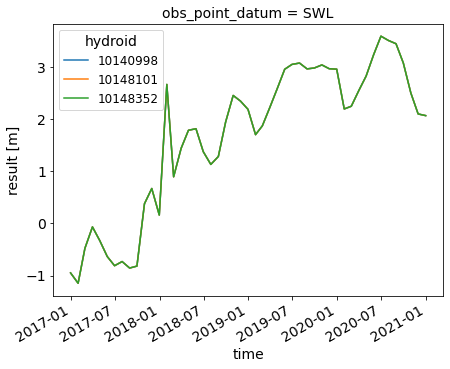

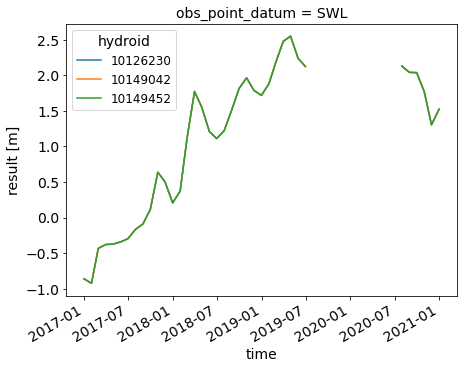

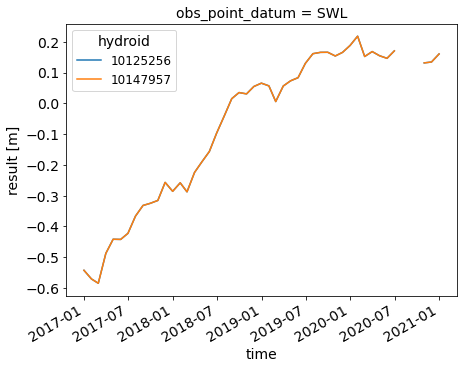

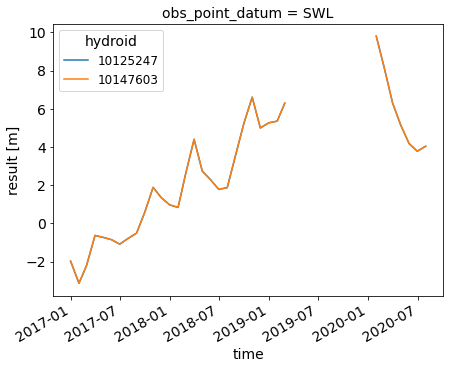

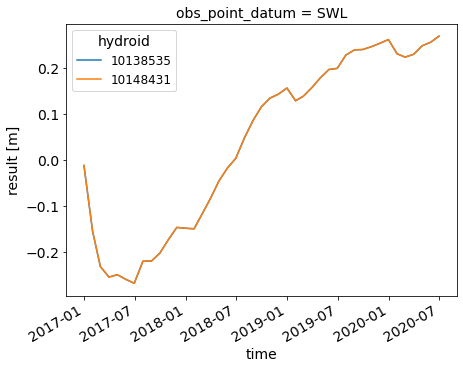

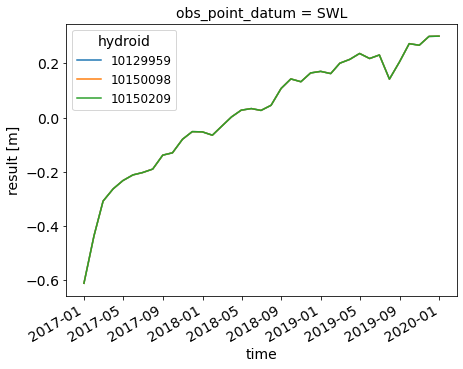

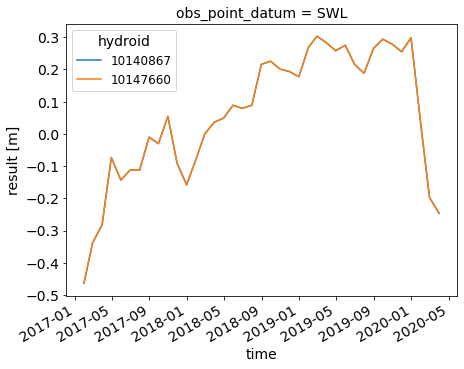

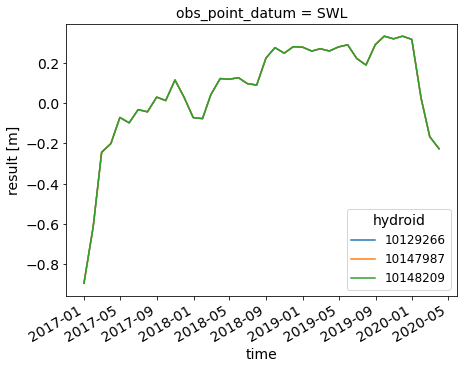

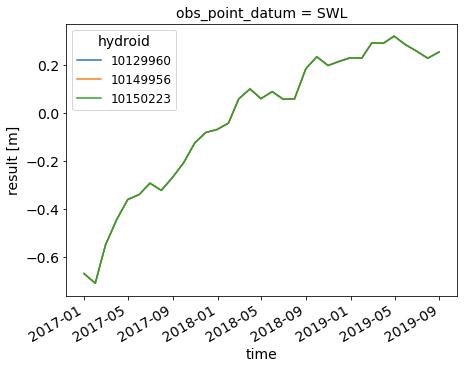

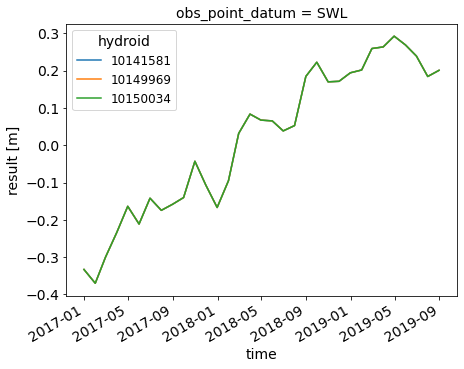

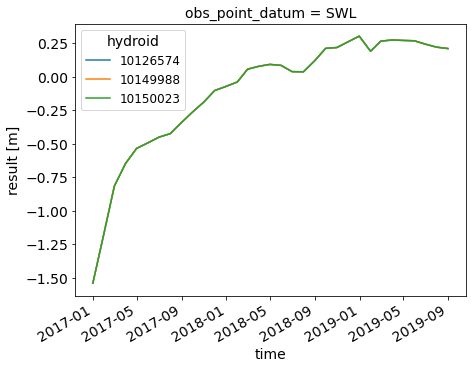

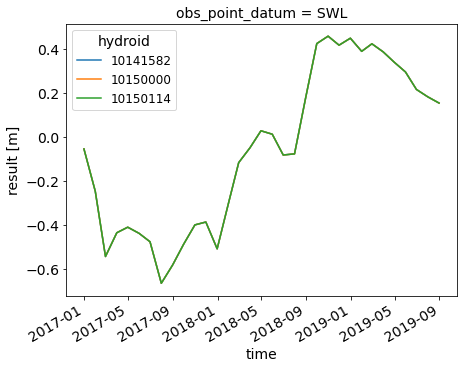

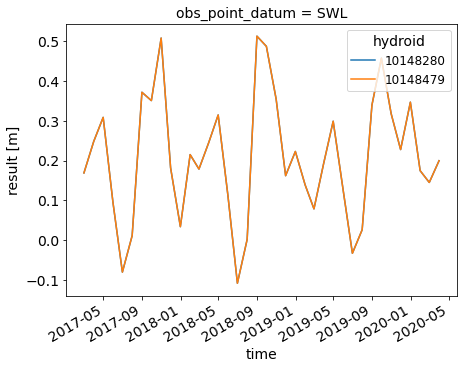

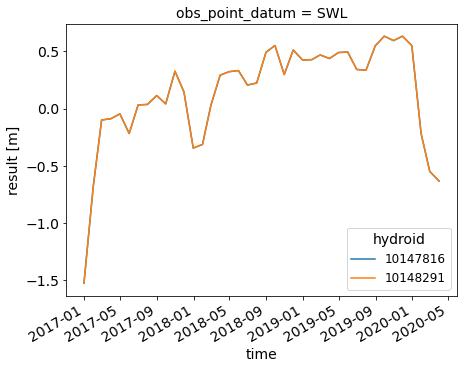

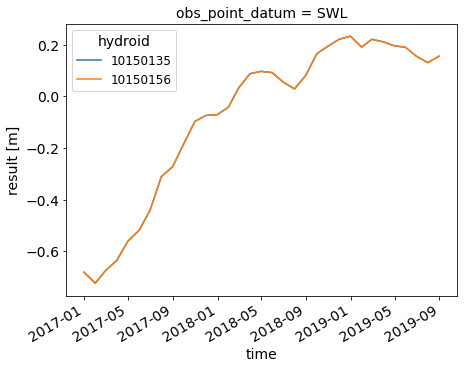

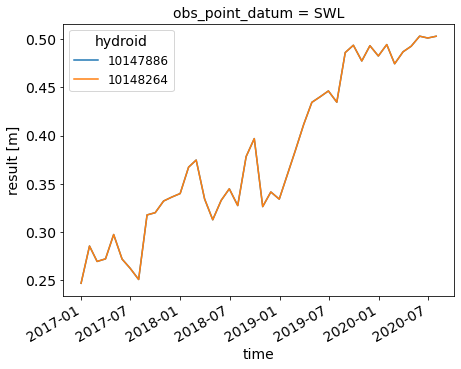

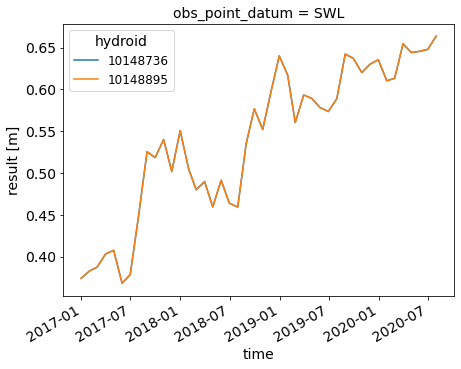

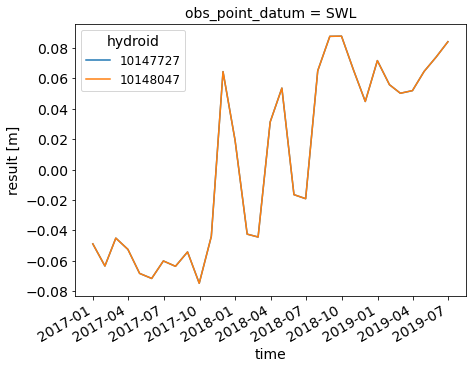

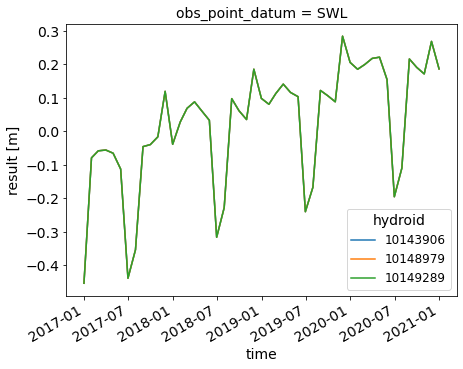

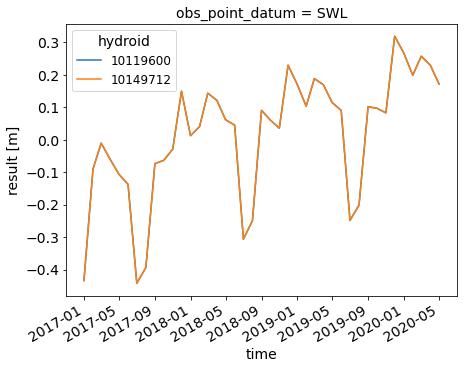

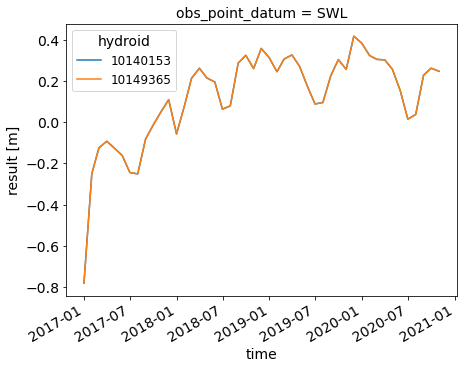

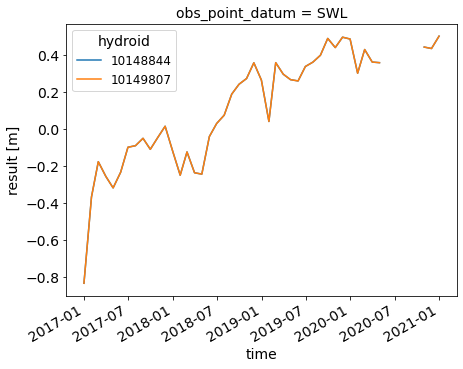

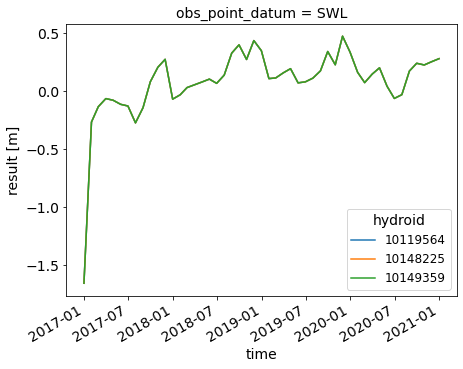

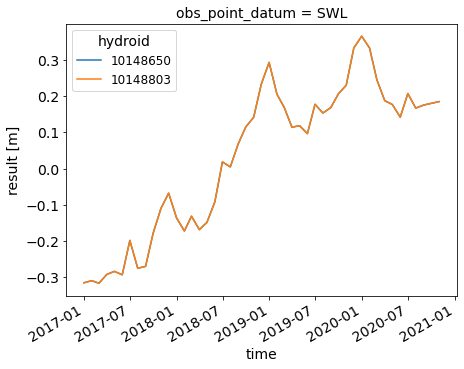

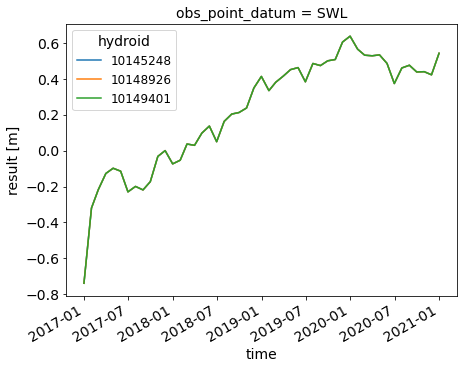

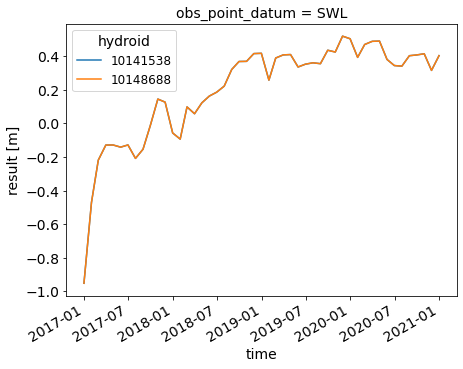

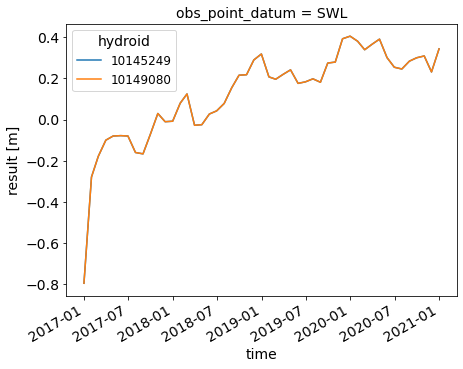

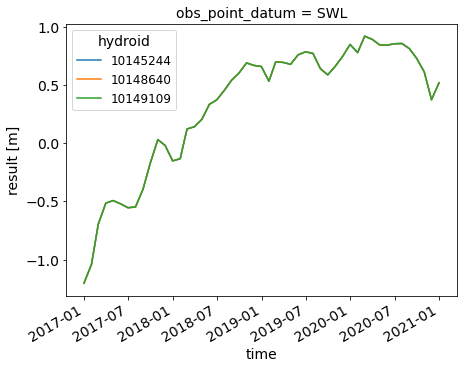

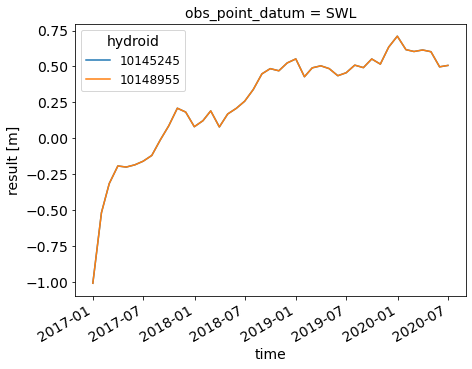

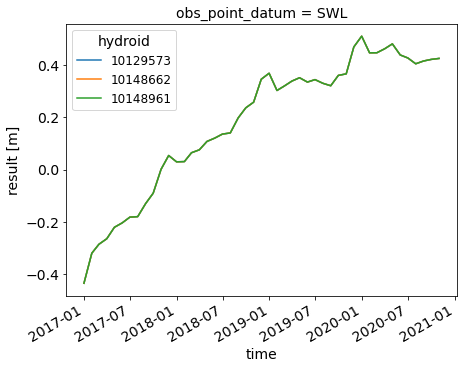

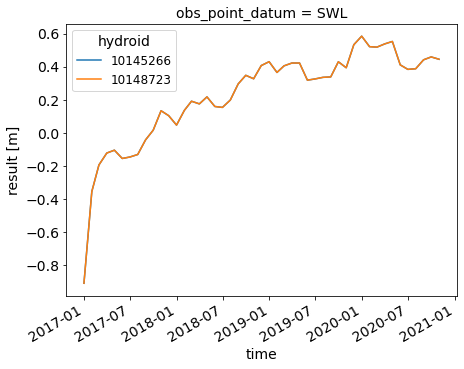

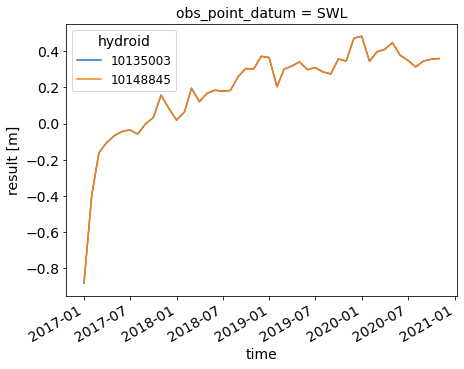

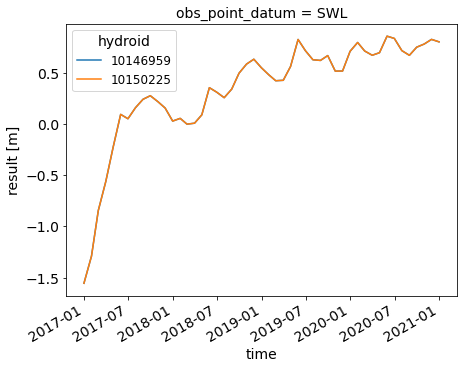

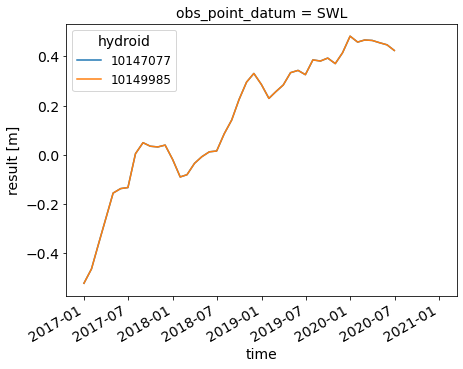

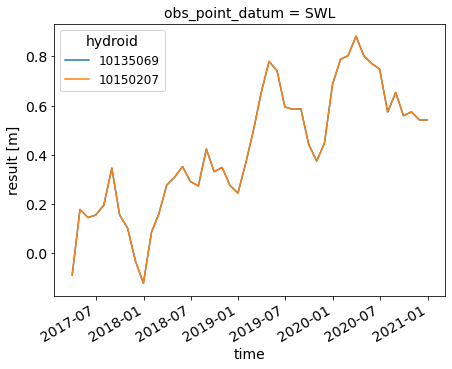

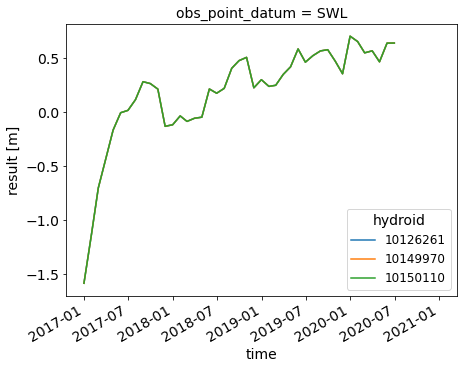

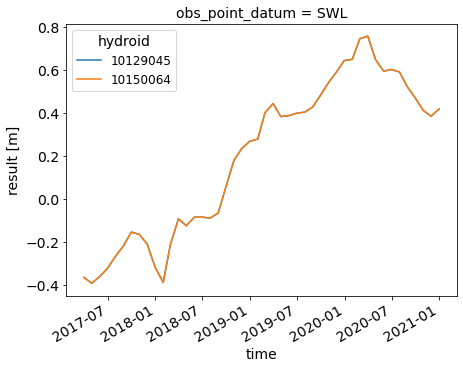

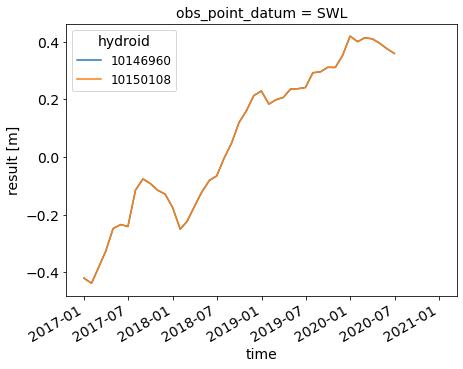

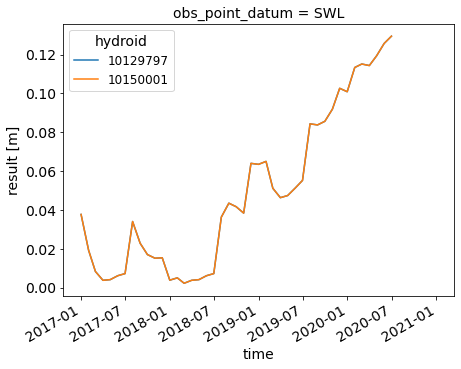

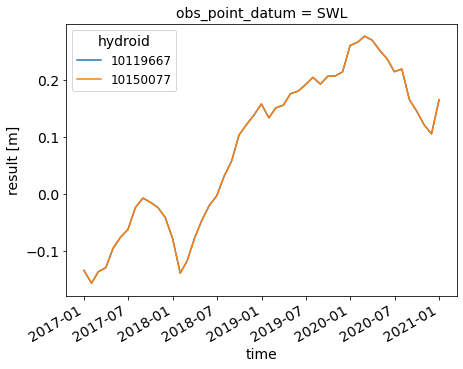

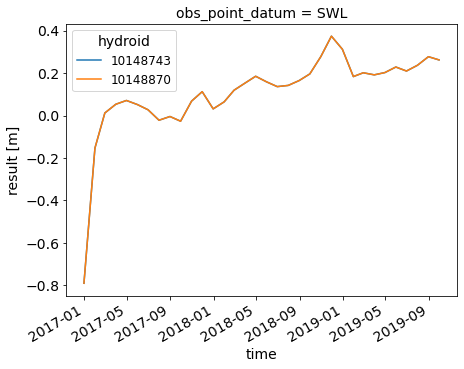

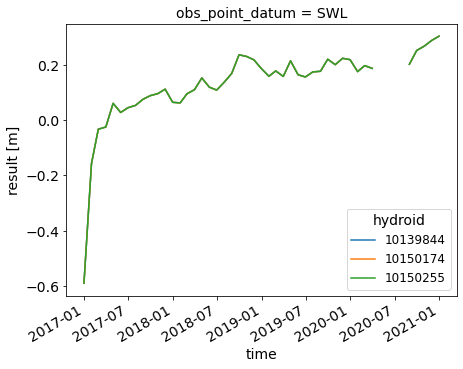

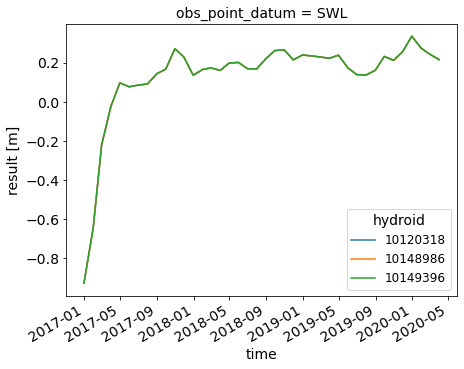

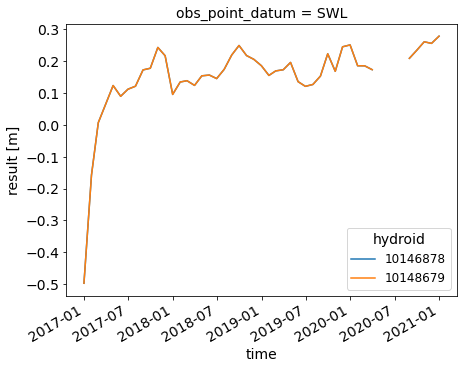

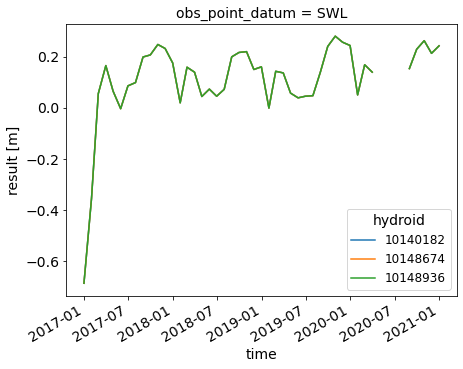

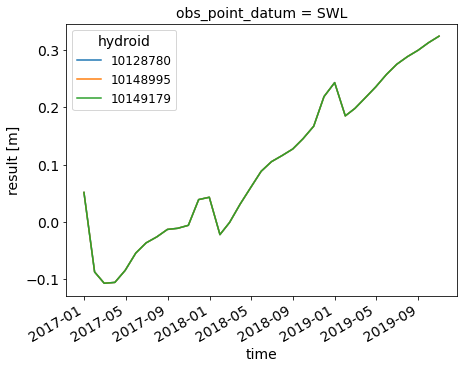

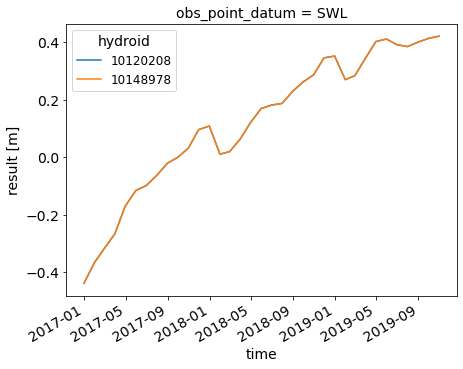

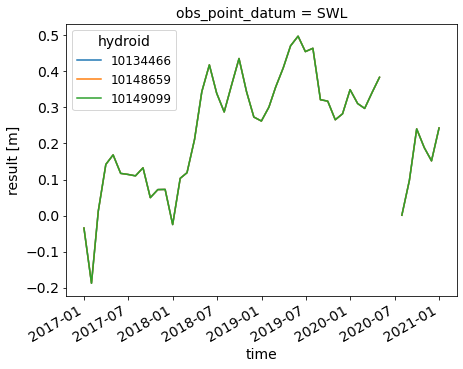

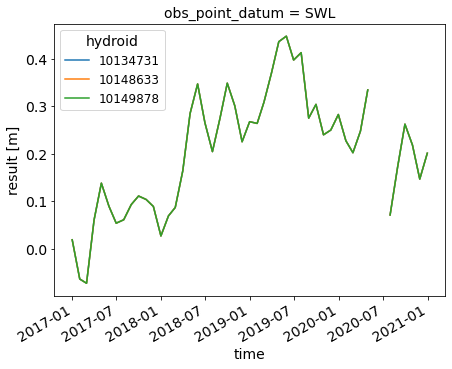

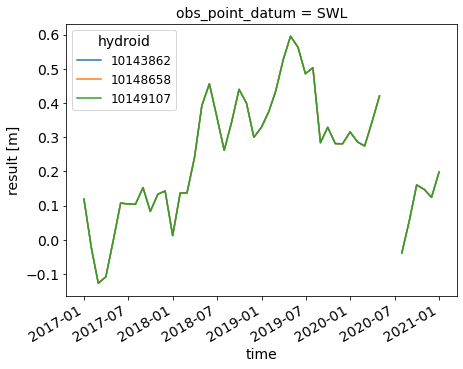

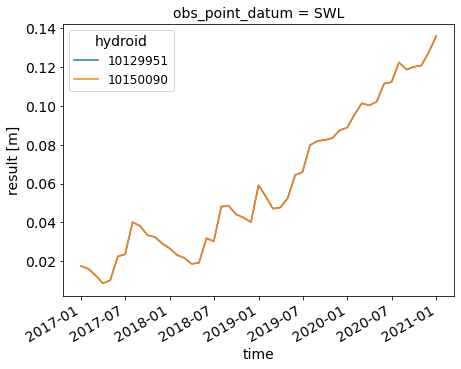

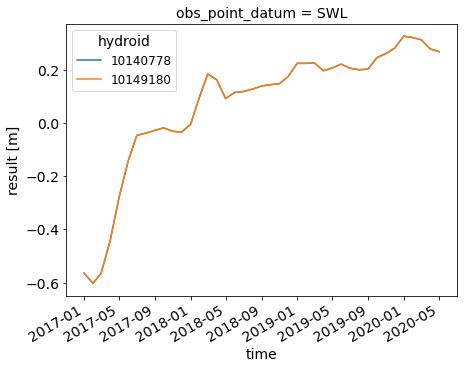

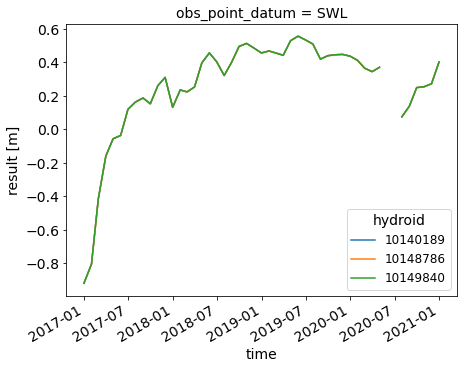

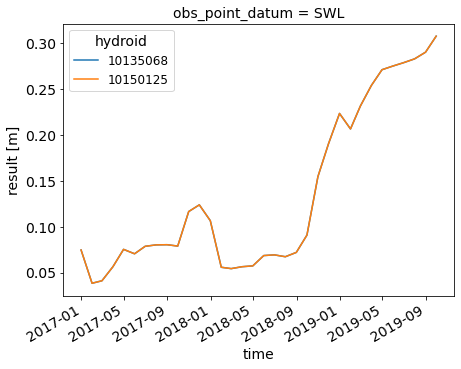

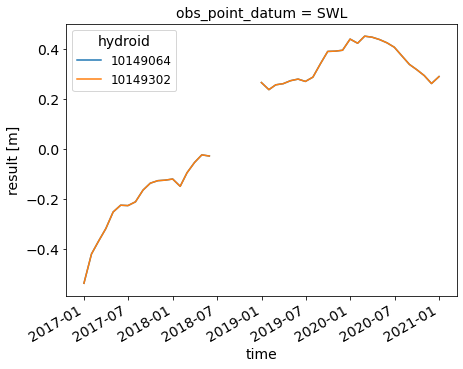

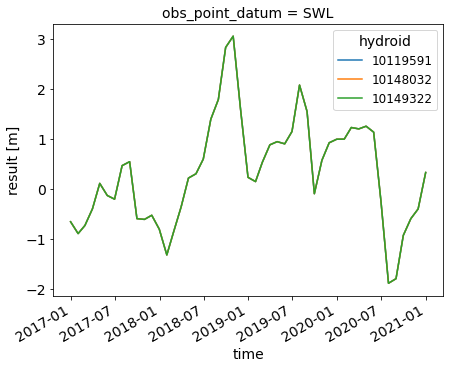

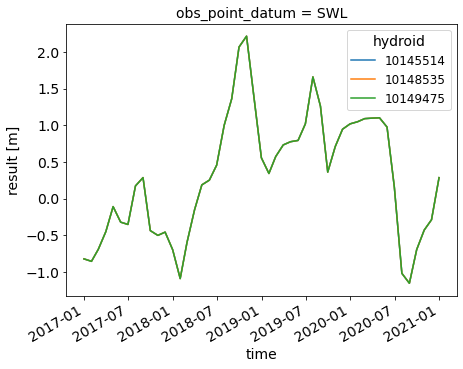

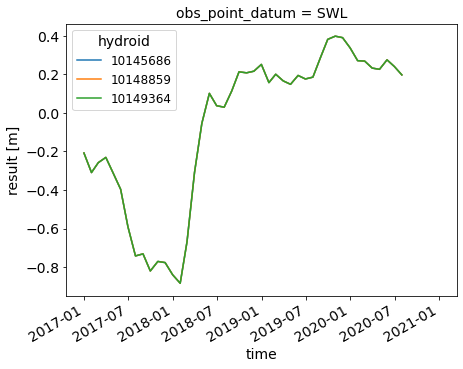

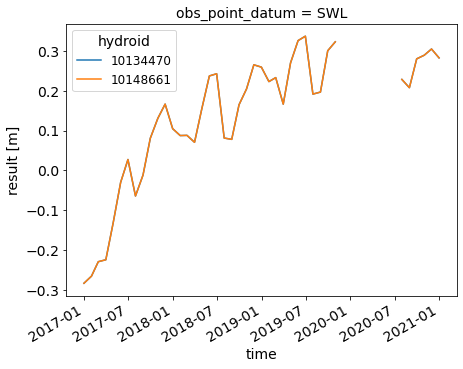

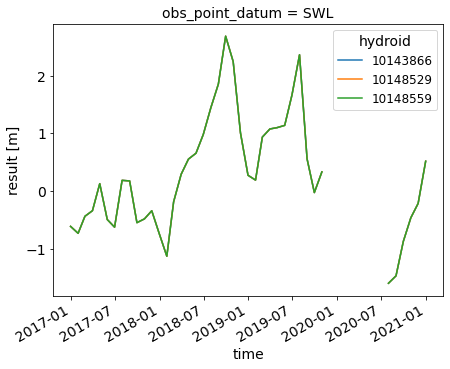

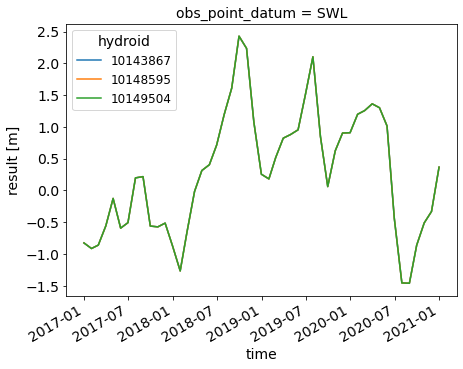

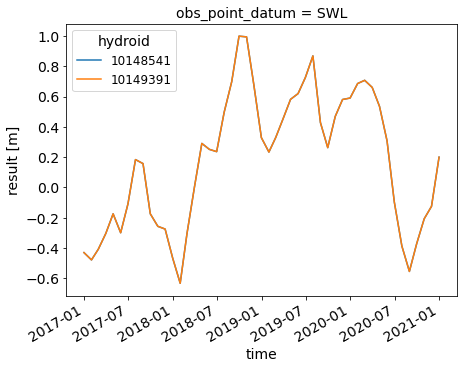

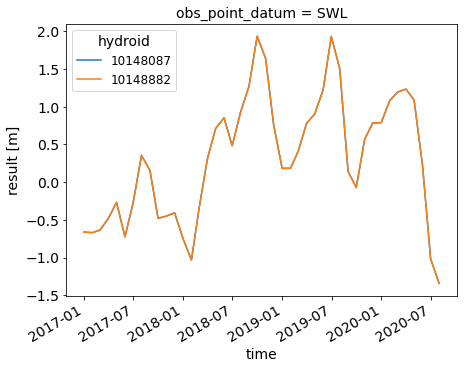

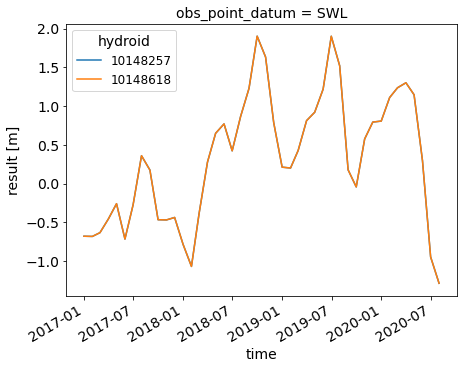

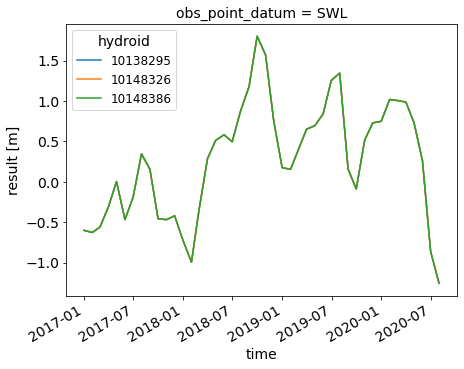

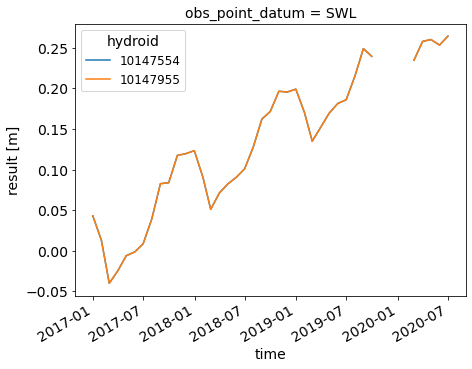

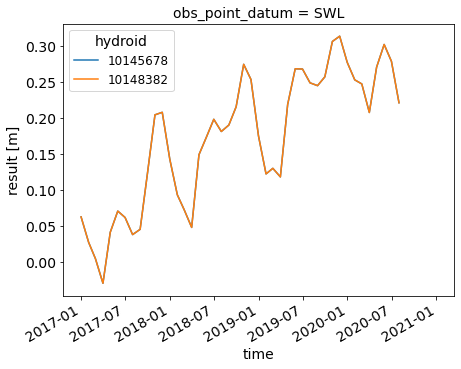

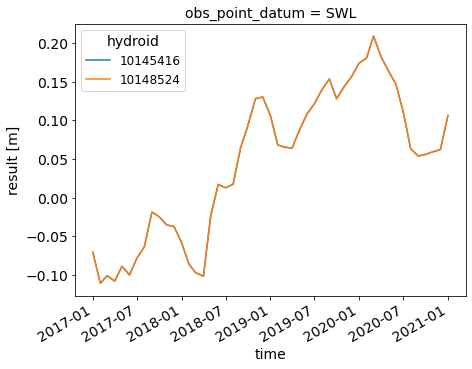

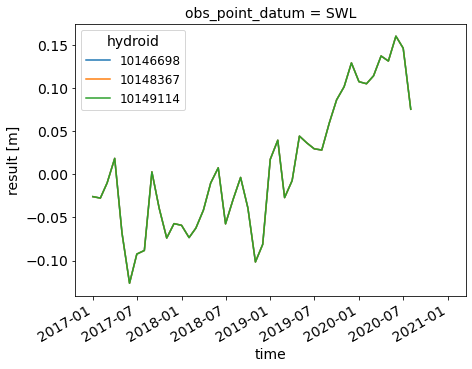

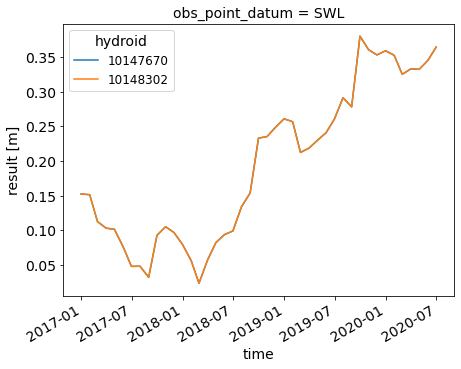

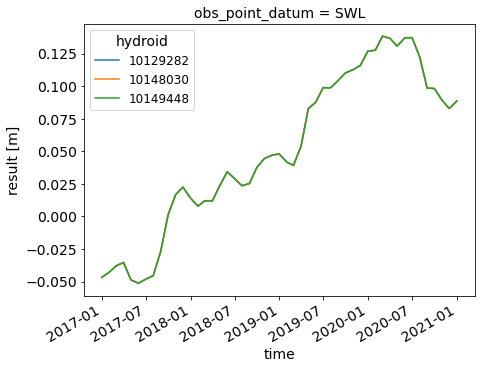

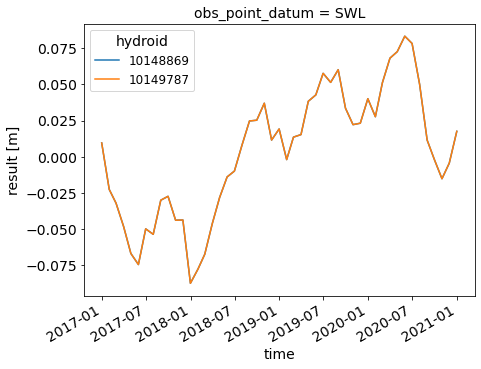

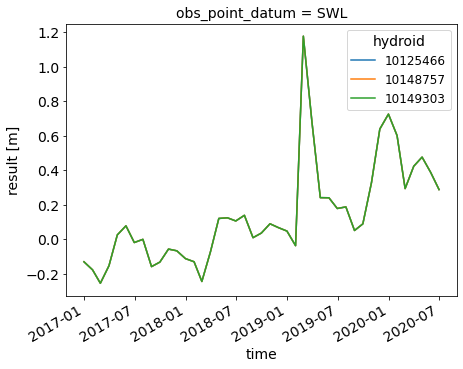

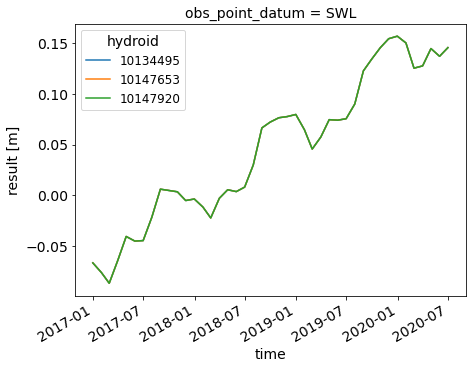

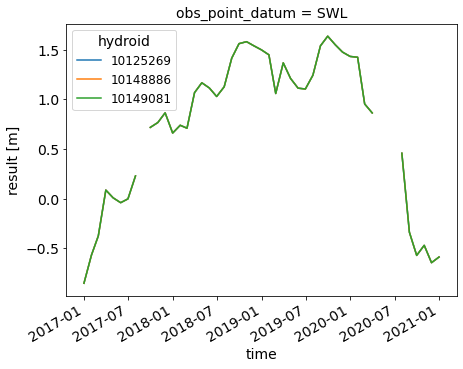

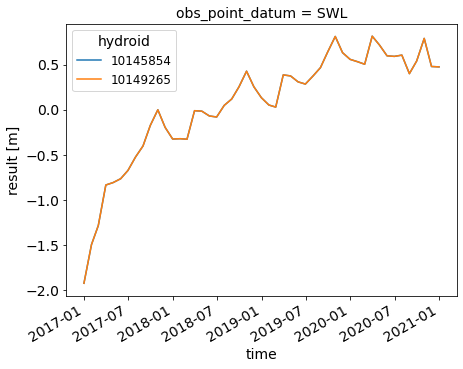

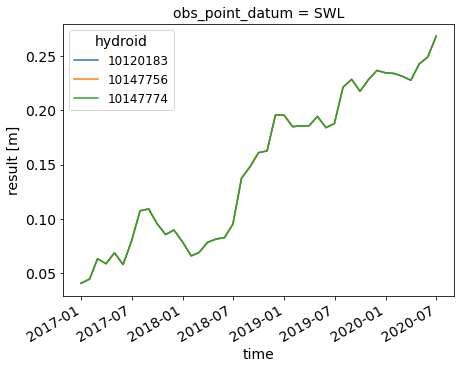

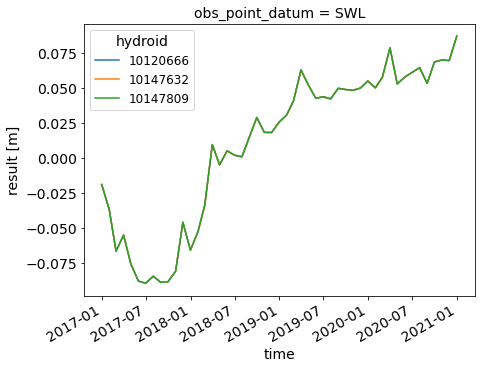

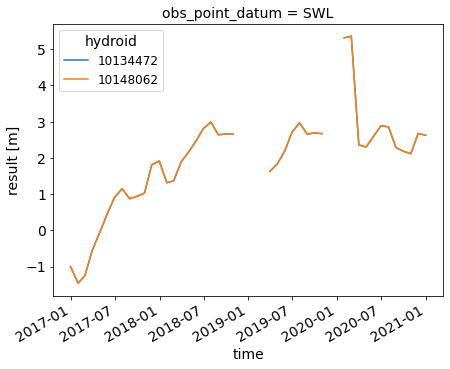

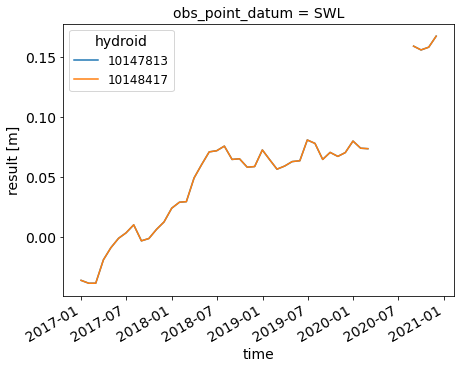

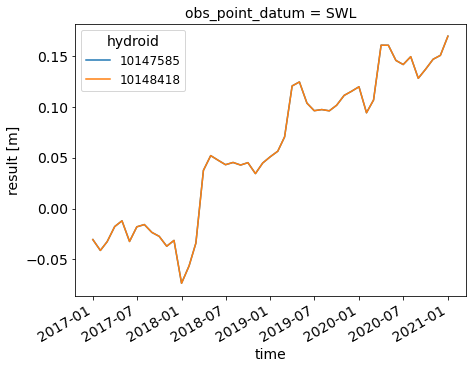

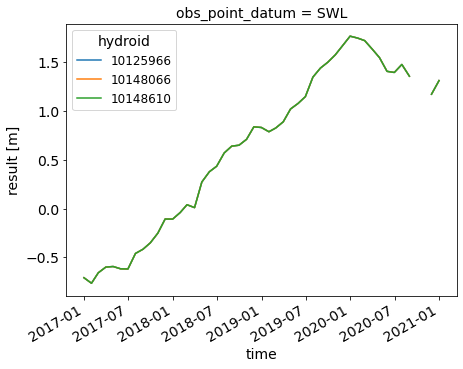

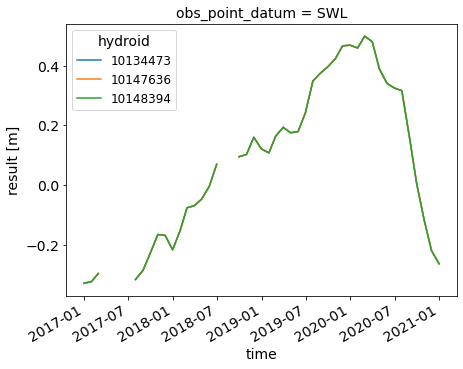

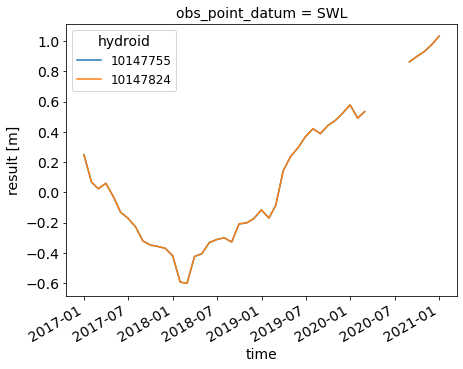

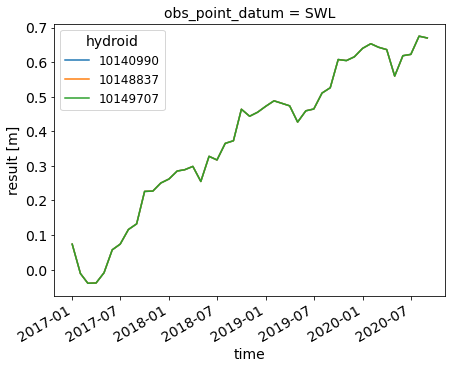

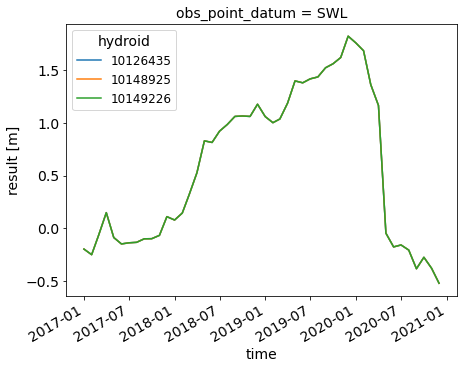

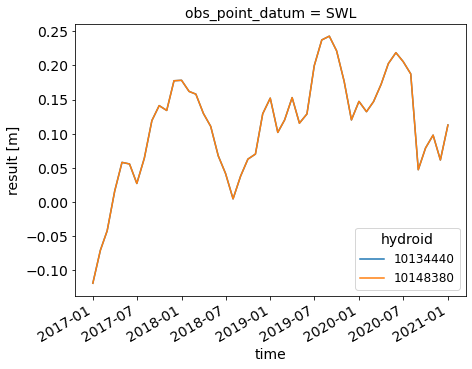

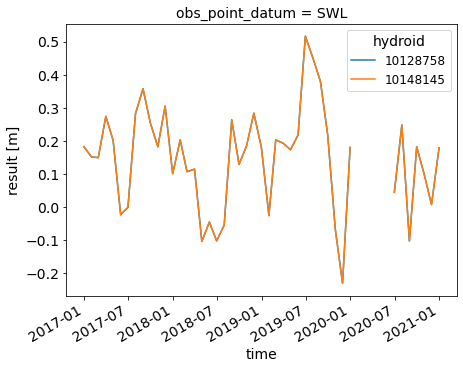

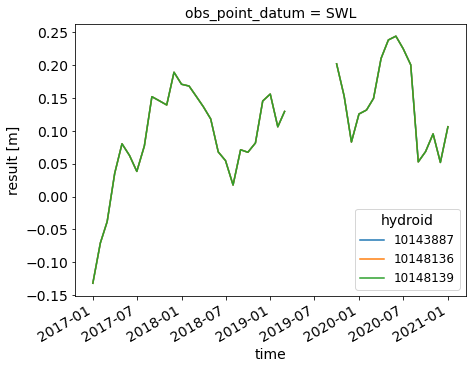

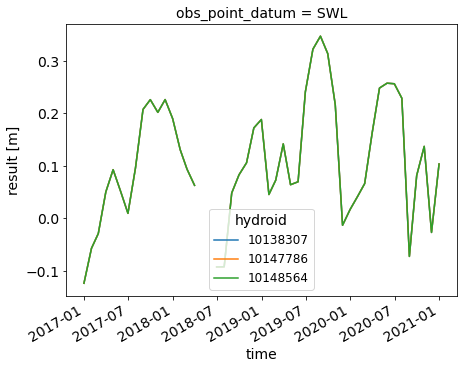

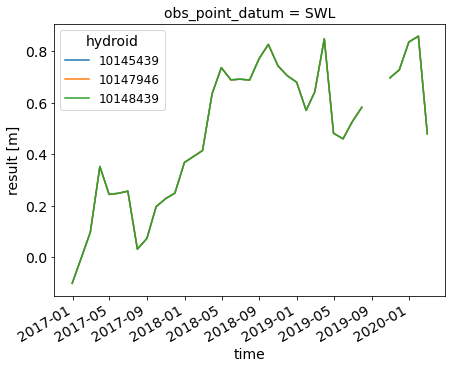

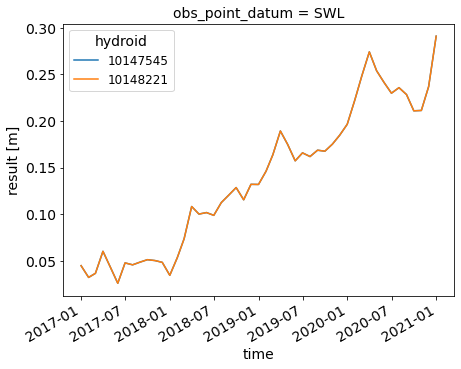

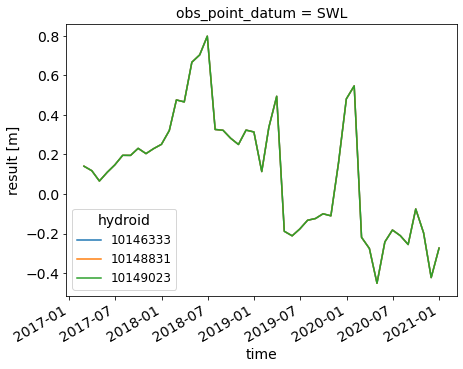

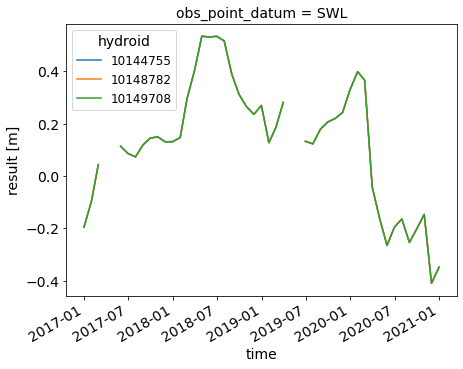

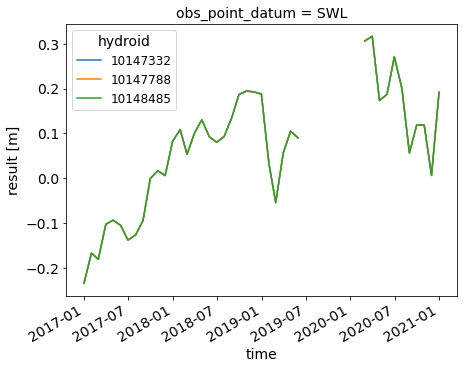

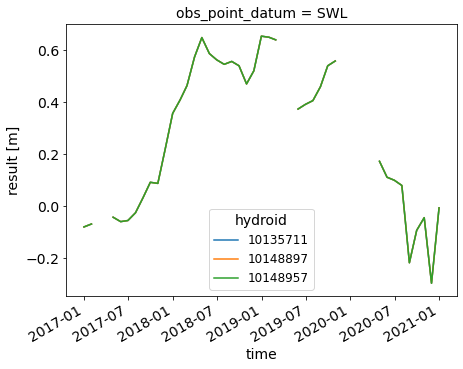

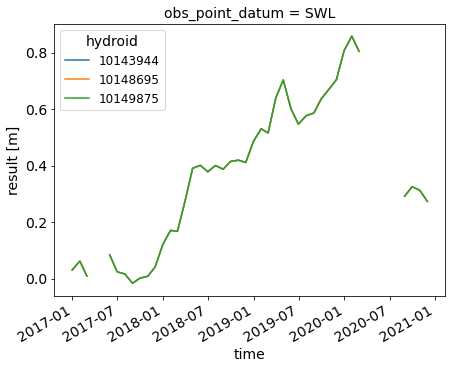

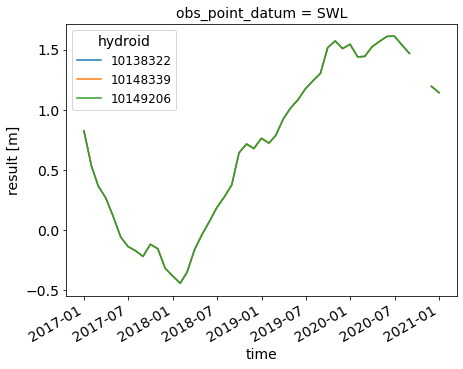

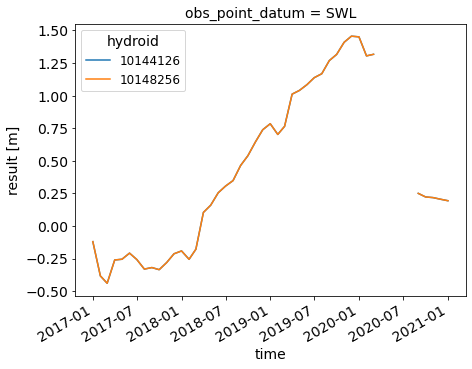

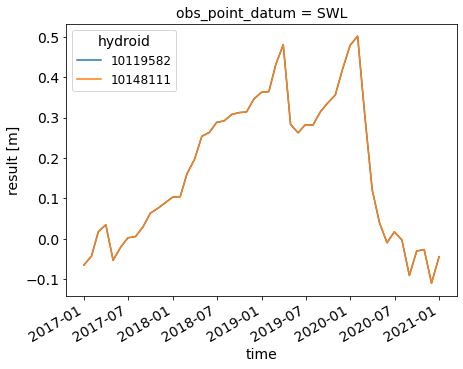

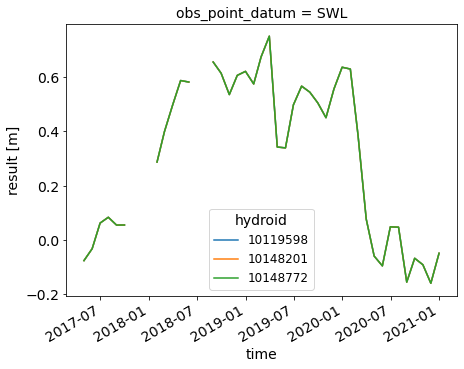

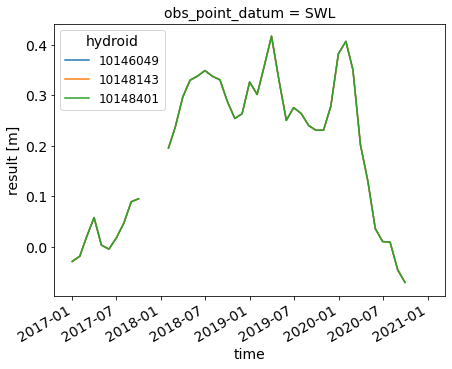

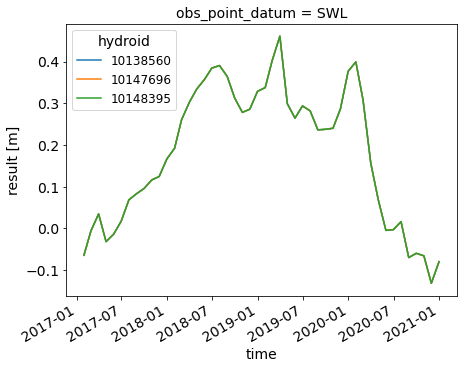

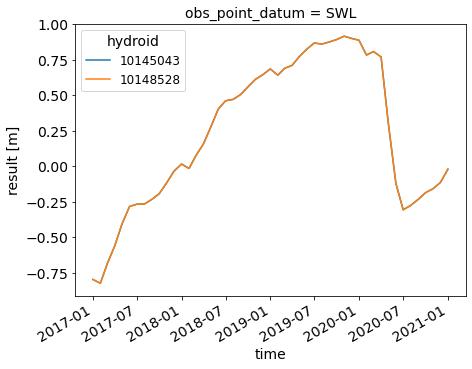

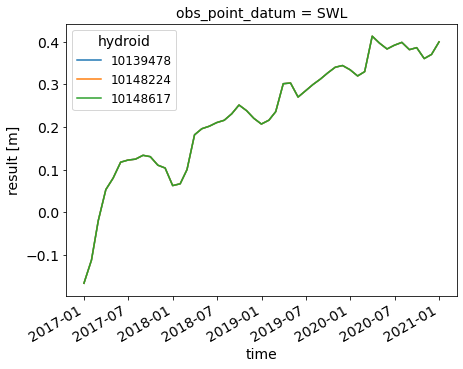

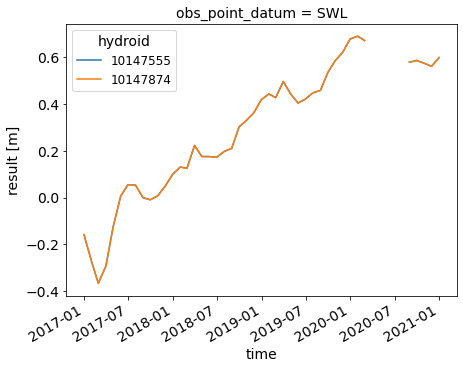

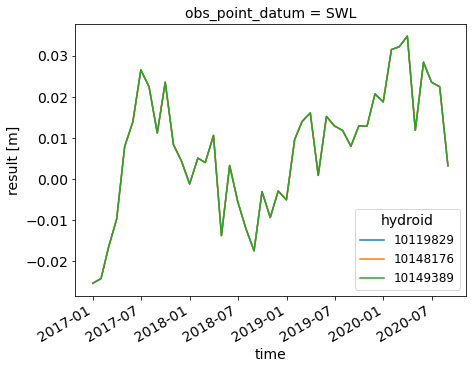

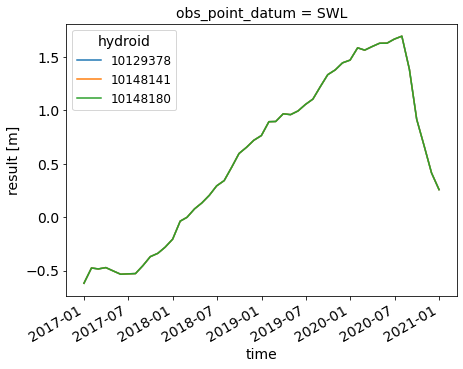

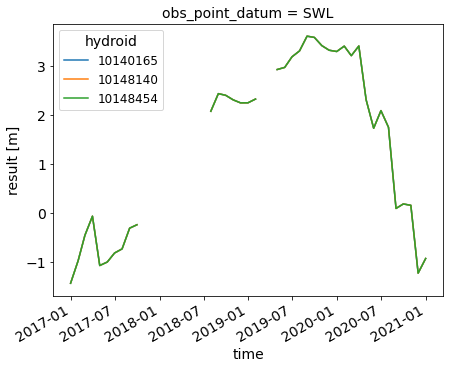

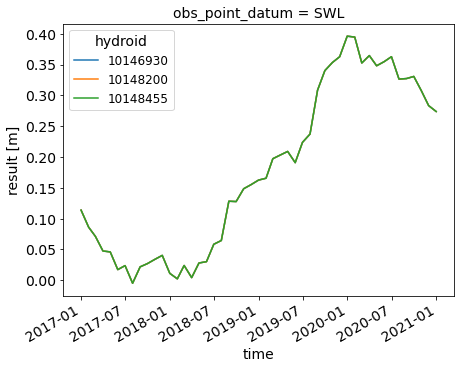

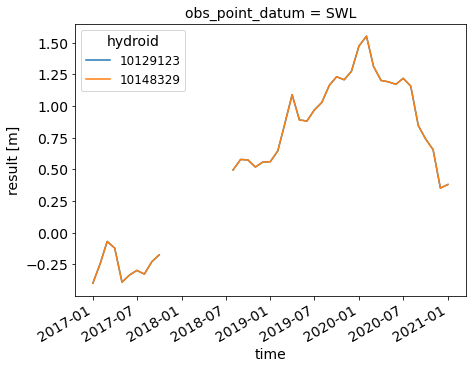

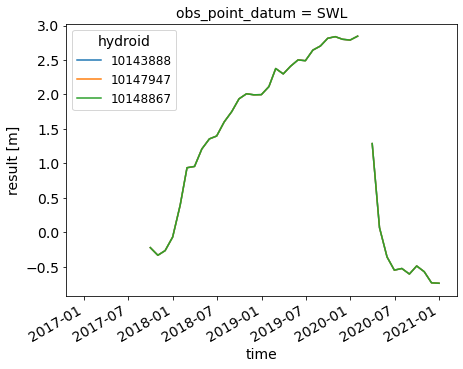

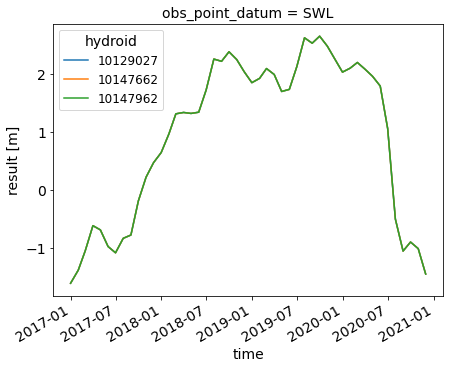

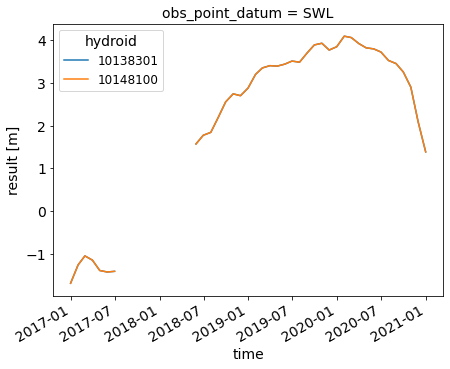

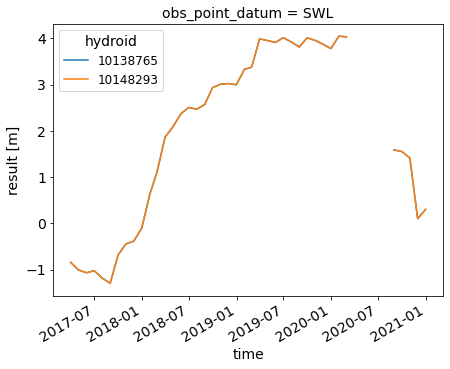

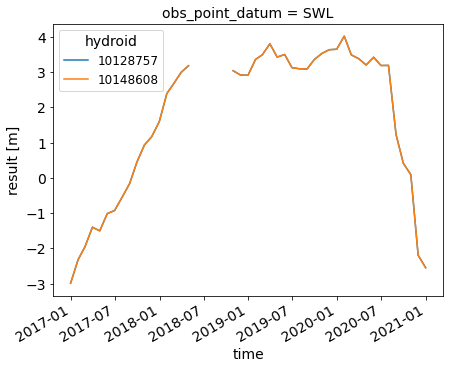

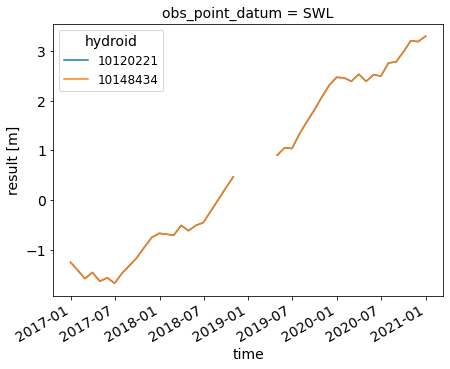

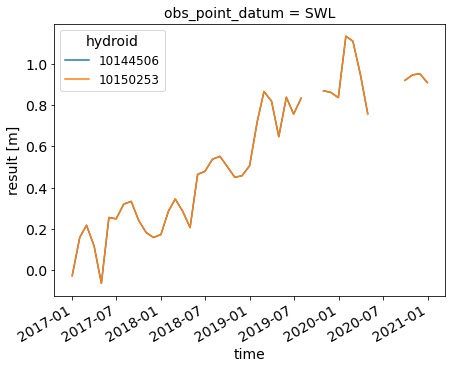

In [25]:
datum_sel = 'SWL'

for i in range(len(df_latlon_duplicates)):
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,5)) #width, height
    dup_hydroids = df_gw_latlon[(df_gw_latlon['lat'] == df_latlon_duplicates['lat'].values[i]) & (df_gw_latlon['lon'] == df_latlon_duplicates['lon'].values[i]) & (df_gw_latlon['clim'] == df_latlon_duplicates['clim'].values[i])].hydroid.values
    da_monAnom.sel(hydroid = dup_hydroids, obs_point_datum = datum_sel).plot(hue = 'hydroid', ax=ax)

In [17]:
da_lt_monClim = da_lt_monClim.isel(hydroid = ~dup_hydroids)
da_monAnom = da_monAnom.isel(hydroid = ~dup_hydroids)

In [18]:
da_NSW_lt_monClim_post2010 = da_lt_monClim
da_NSW_monAnom_post2010 = da_monAnom

In [12]:
da_NSW_lt_monClim = da_lt_monClim
da_NSW_monAnom = da_monAnom

### Anomaly plots

In [9]:
# save lat-lons after removing the duplicates

# da_lat = ds_gw.isel(hydroid = ~dup_hydroids)['Latitude'].mean(['time', 'obs_point_datum'])
# da_lon = ds_gw.isel(hydroid = ~dup_hydroids)['Longitude'].mean(['time', 'obs_point_datum'])

# out_csv_file = '/g/data/w97/ad9701/drought_2017to2020/borewell/subset_bores_NSW_latlon_noDuplicates.csv'

# df_gw_latlon = pd.DataFrame({'lat': da_lat.values, 'lon': da_lon.values, 'hydroid': da_lat.hydroid.values})
# df_gw_latlon.to_csv(out_csv_file)

In [57]:
# DTW measurements are missing at some wells. Using SWL measurements at those locations.

hydroids_noDTW = da_lt_monClim.sel(obs_point_datum = 'DTW').count('month').values == 0

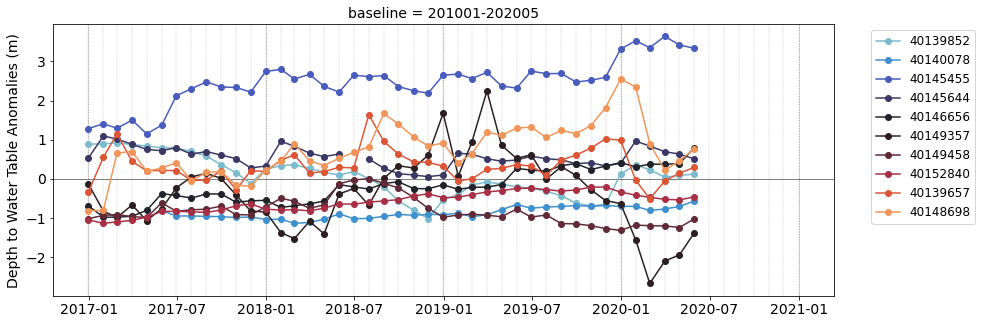

In [58]:
state = 'QLD'

fig_dir = 'figures/drought_2017to2020/borewell/'

nWells = len(da_monAnom.hydroid.values)
col_sel = sns.color_palette("icefire", nWells)

datum_sel = 'DTW'
data_list = [da_monAnom.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_monAnom.hydroid.values[~hydroids_noDTW]]
data_names = list(da_monAnom.hydroid.values[~hydroids_noDTW])

# add SWL measurements for wells where the DTW measurements are unavailable
datum_sel = 'SWL'
data_list_swl = [da_monAnom.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_monAnom.hydroid.values[hydroids_noDTW]]
data_list.extend(data_list_swl)
data_names.extend(list(da_monAnom.hydroid.values[hydroids_noDTW]))

fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(14,5)) #width, height

seas_breaks = pd.date_range('2016-12-31', freq='M', periods=12*4+1).to_numpy()#.astype(float)
year_breaks = pd.date_range('2016-12-31', freq='Y', periods=5).to_numpy()

for xline in seas_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)
for da, color, label in zip(data_list, col_sel, data_names):
    plt.plot(da.time.values, da.values, marker='o', color=color, label=label)

    xx = da.resample(time="QS-DEC").mean().time.values + np.timedelta64(45, 'D')
    array_time = [x.astype('datetime64[D]') for x in xx]
    array_val = da.resample(time="QS-DEC").mean().values
    #plt.bar(array_time, array_val, width=85, edgecolor='white', color=color, alpha=0.2)

plt.xlabel('')
plt.ylabel('Depth to Water Table Anomalies (m)')
plt.title(ref_title)
#plt.ylim((-2.5, 2.5))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
fig.savefig(fig_dir + state + '_water_level_anom_from_monClim_' + fig_suffix + '.png', bbox_inches='tight', dpi = 600)
fig.savefig(fig_dir + state + '_water_level_anom_from_monClim_' + fig_suffix + '.pdf', bbox_inches='tight', format = 'pdf')

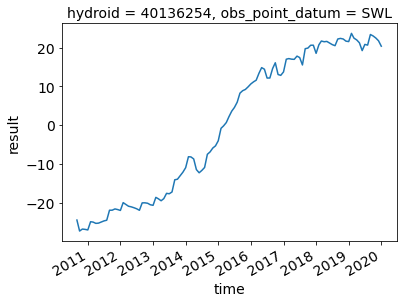

In [39]:
(da_mon.groupby('time.month') - da_lt_monClim).sel(hydroid = 40136254, obs_point_datum = 'SWL').plot()

In [ ]:
(da_mon.groupby('time.month') - da_lt_monClim).sel(hydroid = [40136254, obs_point_datum = 'SWL').plot(hue = 'hydroid')

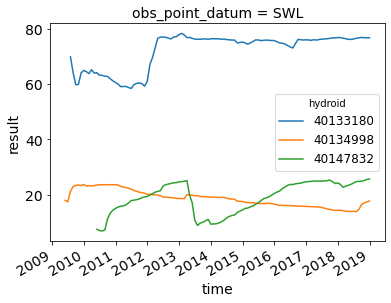

In [60]:
(da_mon).sel(hydroid = [40133180, 40134998, 40147832], obs_point_datum = 'SWL').plot(hue = 'hydroid')

### Seasonal bars & monthly boxplots

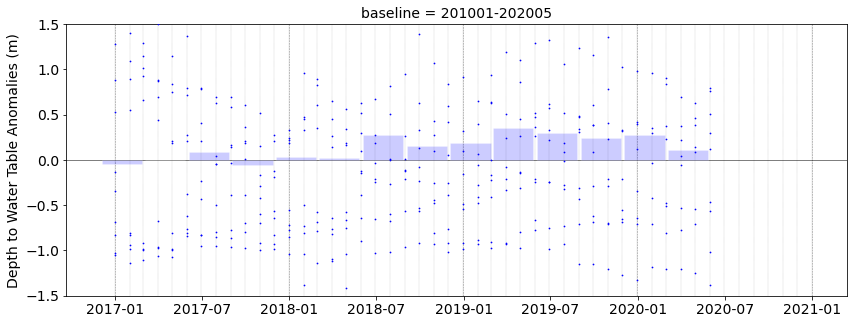

In [68]:
import matplotlib

nWells = len(da_monAnom.hydroid.values)
col_sel = sns.color_palette("icefire", nWells)

datum_sel = 'DTW'
data_list = [da_monAnom.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_monAnom.hydroid.values[~hydroids_noDTW]]

# add SWL measurements for wells where the DTW measurements are unavailable
datum_sel = 'SWL'
data_list_swl = [da_monAnom.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_monAnom.hydroid.values[hydroids_noDTW]]
data_list.extend(data_list_swl)

da_anom_all = xr.concat(data_list, dim = 'wells')
da_anom_mean = da_anom_all.mean('wells')

fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(14,5)) #width, height

seas_breaks = pd.date_range('2016-12-31', freq='M', periods=12*4+1).to_numpy()#.astype(float)
year_breaks = pd.date_range('2016-12-31', freq='Y', periods=5).to_numpy()

for xline in seas_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)
# for da, color in zip(data_list, col_sel):
for da, color in zip(data_list, col_sel):
    plt.plot(da.time.values, da.values, marker='o', color='blue', label=None, linewidth=0, markersize=0.75, zorder=10)

xx = da_anom_mean.resample(time="QS-DEC").mean().time.values + np.timedelta64(45, 'D')
array_time = [x.astype('datetime64[D]') for x in xx]
array_val = da_anom_mean.resample(time="QS-DEC").mean().values
plt.bar(array_time, array_val, width=85, edgecolor='white', color='blue', alpha=0.2, zorder=5)

#bp = plt.boxplot(da_anom_all.values, positions=matplotlib.dates.date2num(da_anom_all.time.values), sym='.', widths=0.12, patch_artist=True) #, notch = True)
#myfuncs.set_box_color(bp, 'blue')

plt.xlabel('')
plt.ylabel('Depth to Water Table Anomalies (m)')
plt.title(ref_title)
plt.ylim((-1.5, 1.5))
#plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
fig.savefig(fig_dir + state + '_water_level_anom_from_mon_and_seas_' + fig_suffix + '.png', bbox_inches='tight', dpi = 600)
fig.savefig(fig_dir + state + '_water_level_anom_from_mon_and_seas_' + fig_suffix + '.pdf', bbox_inches='tight', format = 'pdf')

### Combining data from NSW and QLD

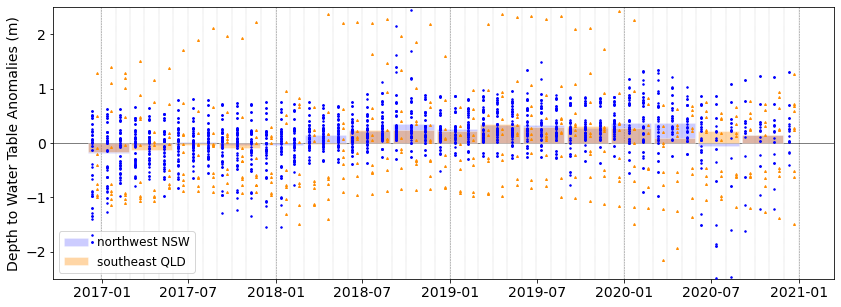

In [21]:
import matplotlib
fig_dir = 'figures/drought_2017to2020/borewell/'

########
# NSW
########

hydroids_noDTW_NSW = da_NSW_lt_monClim.sel(obs_point_datum = 'DTW').count('month').values == 0

datum_sel = 'DTW'
data_list_NSW = [da_NSW_monAnom.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_NSW_monAnom.hydroid.values[~hydroids_noDTW_NSW]]

# add SWL measurements for wells where the DTW measurements are unavailable
datum_sel = 'SWL'
data_list_swl = [da_NSW_monAnom.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_NSW_monAnom.hydroid.values[hydroids_noDTW_NSW]]
data_list_NSW.extend(data_list_swl)

da_NSW_anom_all = xr.concat(data_list_NSW, dim = 'wells')
da_NSW_anom_mean = da_NSW_anom_all.mean('wells')

########
# QLD
########

hydroids_noDTW_QLD = da_QLD_lt_monClim.sel(obs_point_datum = 'DTW').count('month').values == 0

datum_sel = 'DTW'
data_list_QLD = [da_QLD_monAnom.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_QLD_monAnom.hydroid.values[~hydroids_noDTW_QLD]]

# add SWL measurements for wells where the DTW measurements are unavailable
datum_sel = 'SWL'
data_list_swl = [da_QLD_monAnom.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_QLD_monAnom.hydroid.values[hydroids_noDTW_QLD]]
data_list_QLD.extend(data_list_swl)

da_QLD_anom_all = xr.concat(data_list_QLD, dim = 'wells')
da_QLD_anom_mean = da_QLD_anom_all.mean('wells')

#######
# PLOT
#######

col_NSW = 'blue'
col_QLD = 'darkorange'

fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(14,5)) #width, height

seas_breaks = pd.date_range('2016-12-31', freq='M', periods=12*4+1).to_numpy()#.astype(float)
year_breaks = pd.date_range('2016-12-31', freq='Y', periods=5).to_numpy()

for xline in seas_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)
# for da, color in zip(data_list, col_sel):
for da in data_list_NSW:
    plt.plot(da.time.values - np.timedelta64(20, 'D'), da.values, marker='o', color=col_NSW, label=None, linewidth=0, markersize=1.5, zorder=10)
    
for da in data_list_QLD:
    plt.plot(da.time.values - np.timedelta64(10, 'D'), da.values, marker='^', color=col_QLD, label=None, linewidth=0, markersize=2, zorder=10) #, edgecolors='black')

xx = da_NSW_anom_mean.resample(time="QS-DEC").mean().time.values + np.timedelta64(45, 'D')
array_time = [x.astype('datetime64[D]') for x in xx]
array_val_NSW = da_NSW_anom_mean.resample(time="QS-DEC").mean().values
plt.bar(array_time[0:-1], array_val_NSW[0:-1], width=85, edgecolor='white', color=col_NSW, alpha=0.2, zorder=5, label = 'northwest NSW')

xx = da_QLD_anom_mean.resample(time="QS-DEC").mean().time.values + np.timedelta64(45, 'D')
array_time = [x.astype('datetime64[D]') for x in xx]
array_val_QLD = da_QLD_anom_mean.resample(time="QS-DEC").mean().values
plt.bar(array_time[0:-1], array_val_QLD[0:-1], width=85, edgecolor='white', color=col_QLD, alpha=0.35, zorder=5, label = 'southeast QLD')

#bp = plt.boxplot(da_anom_all.values, positions=matplotlib.dates.date2num(da_anom_all.time.values), sym='.', widths=0.12, patch_artist=True) #, notch = True)
#myfuncs.set_box_color(bp, 'blue')

plt.xlabel('')
plt.ylabel('Depth to Water Table Anomalies (m)')
# plt.title(ref_title)
plt.ylim((-2.5, 2.5))
plt.legend(loc="lower left")  #bbox_to_anchor=(1.04,1), 
fig.savefig(fig_dir + 'NSWnQLD_water_level_anom_from_mon_and_seas.png', bbox_inches='tight', dpi = 600)
fig.savefig(fig_dir + 'NSWnQLD_water_level_anom_from_mon_and_seas.pdf', bbox_inches='tight', format = 'pdf')

In [66]:
%who

BIGGER_SIZE	 LATITUDE_FORMATTER	 LONGITUDE_FORMATTER	 MEDIUM_SIZE	 SMALL_SIZE	 add_cyclic_point	 agcd_info	 alldata_dict	 array_time	 
array_val	 awra_info	 ax	 baseline	 bool_hydroid	 ccrs	 cfeature	 chirps_info	 clim	 
col	 col_sel	 cticker	 da_NSW_anom_all	 da_NSW_anom_mean	 da_NSW_lt_monClim	 da_NSW_lt_monClim_post2010	 da_NSW_monAnom	 da_NSW_monAnom_post2010	 
da_QLD_anom_all	 da_QLD_anom_mean	 da_QLD_lt_monClim	 da_QLD_monAnom	 da_lat	 da_lon	 da_lt_monClim	 da_mon	 da_monAnom	 
da_reg_anom_all	 da_reg_anom_mean	 data	 data_list	 data_list_NSW	 data_list_QLD	 data_list_swl	 data_names	 datetime	 
datum_sel	 df_darling	 df_gw_latlon	 df_gwydir	 df_hunter	 df_lachlan	 df_latlon_duplicates	 df_murrum	 draw_spatial_plot	 
draw_spatial_plot_12panels	 draw_spatial_plot_3panels	 draw_spatial_plot_addcontours	 draw_spatial_plot_addsh	 ds_gw	 dup_hydroids	 era5land_info	 esacci_info	 fig	 
fig_dir	 fig_suffix	 filename	 get_da	 get_da_simple	 gleam_info	 glob	 gpd	 hydroid	 
hydroids_noDT

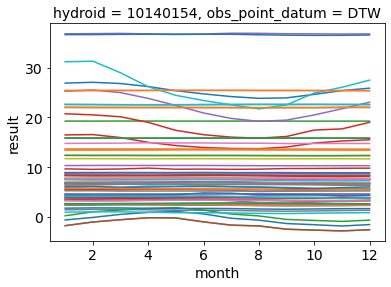

In [67]:
for hid in range(len(da_NSW_lt_monClim_post2010.hydroid)):
    da_NSW_lt_monClim_post2010.isel(obs_point_datum=0, hydroid=hid).plot()

### Anomalies in m (to mention in the text)

In [33]:
df_anom = pd.DataFrame(dict(zip(data_names, [np.round(da.resample(time="QS-DEC").mean(), 5).values*-1 for da in list_for_plot])))
                       #  'perc_anomaly (%)': np.round(anom_seasMean/clim_seasMean*100,1).values,
                       # 'climatology (mm)': np.round(clim_seasMean, 5).values})
df_anom['time'] = list_for_plot[0].resample(time="QS-DEC").mean().time.values
df_anom = df_anom.set_index('time')
print(df_anom)

out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/seas_borewell_level_anomalies_moreData.csv'
df_anom.to_csv(out_file)

            Condamine   Gwydir  Hunter & Namoi  Lachlan  \
time                                                      
2016-12-01    0.05605 -0.11744         0.53116  1.08498   
2017-03-01    0.07445 -0.10401         0.48378  0.39361   
2017-06-01   -0.01257 -0.30138         0.44169  0.29757   
2017-09-01    0.07378 -0.19542         0.25296 -0.32857   
2017-12-01   -0.00891 -0.26853         0.10839 -0.18802   
2018-03-01    0.10610 -0.31905        -0.02527 -0.54111   
2018-06-01   -0.17582 -0.52304        -0.39839 -0.60831   
2018-09-01   -0.42369 -0.47041        -0.69000 -0.93539   
2018-12-01   -0.30045 -0.69670        -0.60232 -0.70238   
2019-03-01   -0.35032 -0.76811        -0.74938 -0.79262   
2019-06-01   -0.29754 -0.79479        -1.30320 -0.83412   
2019-09-01   -0.31074 -0.86529        -1.53767 -1.12397   
2019-12-01   -0.27013 -1.02608        -1.57822 -0.90003   
2020-03-01   -0.09575 -0.85214        -1.20061 -0.71755   
2020-06-01   -0.22204      NaN        -0.98544 -0.38400 

In [34]:
df_anom = pd.DataFrame(dict(zip(data_names, [np.round(da, 5).values*-1 for da in list_for_plot])))
                       #  'perc_anomaly (%)': np.round(anom_seasMean/clim_seasMean*100,1).values,
                       # 'climatology (mm)': np.round(clim_seasMean, 5).values})
df_anom['time'] = list_for_plot[0].time.values
df_anom = df_anom.set_index('time')
print(df_anom)

out_file_mon = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/mon_borewell_level_anomalies_moreData.csv'
df_anom.to_csv(out_file_mon)

            Condamine   Gwydir  Hunter & Namoi  Lachlan  \
time                                                      
2016-12-31    0.16554  0.02571         0.58894  1.39003   
2017-01-31    0.08445 -0.15963         0.54202  1.03313   
2017-02-28   -0.08184 -0.21840         0.46253  0.83179   
2017-03-31   -0.00066 -0.11841         0.35182  0.37557   
2017-04-30    0.15816  0.06219         0.55546  0.40104   
2017-05-31    0.06585 -0.25580         0.54406  0.40423   
2017-06-30   -0.03249 -0.24951         0.53282  0.33914   
2017-07-31    0.00820 -0.32064         0.45654  0.14964   
2017-08-31   -0.01342 -0.33400         0.33572  0.40393   
2017-09-30   -0.00616 -0.24317         0.26979 -0.27071   
2017-10-31    0.12463 -0.18372         0.28654 -0.38193   
2017-11-30    0.10287 -0.15937         0.20254 -0.33306   
2017-12-31    0.03915 -0.17332         0.17045 -0.16658   
2018-01-31   -0.04503 -0.28672         0.08412 -0.20767   
2018-02-28   -0.02085 -0.34554         0.07061 -0.18982 

## Spatial plot of seasonal anomalies
Work on this later if relevant

In [65]:
array_val

array([-0.04019473, -0.00149798,  0.08520963, -0.05927034,  0.0282664 ,
        0.01600859,  0.27940986,  0.14989465,  0.18159144,  0.34848637,
        0.29355514,  0.24118031,  0.27862071,  0.11159743])

In [64]:
monArray = da_monAnom['time.month'].values
da_monClim_for_diff = da_lt_monClim.sel(month = monArray).rename({'season':'time'}).assign_coords({'time':da_flow_seasSel.time.values})

da_for_plot = ((da_flow_seasSel - da_seasClim_for_diff)/da_seasClim_for_diff*100).assign_attrs({'units': '%'})

<xarray.DataArray 'result' (time: 42)>
array([-1.42528802, -1.11116331, -0.64672798, -0.30295187,  0.06267333,
       -0.23366338, -0.45200724, -0.24376344, -0.24122504, -1.35987137,
       -1.29493454, -1.40164613, -1.57496544, -1.54148589, -0.7735137 ,
       -0.26262929,  0.16900667,  0.20053017,  0.34932609,  0.68462366,
        1.00135561,  2.07146196,  2.3776461 ,  0.74202054, -0.53173963,
       -0.0663246 ,  0.6164863 ,  0.97608039,  0.89667333,  0.79859468,
        0.90065943,  1.36688172,  0.76103303, -0.85953804, -0.10525712,
        0.05735387,  0.23406682,  0.7820625 ,  1.31152325,  1.29446749,
        1.20534   ,  1.03246565])
Coordinates:
    hydroid          int64 10119591
    obs_point_datum  <U3 'DTW'
  * time             (time) datetime64[ns] 2016-12-31 2017-01-31 ... 2020-05-31
    month            (time) int64 12 1 2 3 4 5 6 7 8 9 ... 9 10 11 12 1 2 3 4 5
Attributes:
    units:    m

In [207]:
# to group wells with similar values together to see seasonal patterns
da_clim_mean = da_lt_monClim.sel(obs_point_datum = 'DTW').mean('month')
da_clim_mean

<xarray.DataArray 'result' (hydroid: 58)>
array([ 1.50008364,         nan,         nan,         nan,         nan,
        6.55327748,  3.21374094,  7.43283923,  4.54795242,         nan,
       10.03018396, 22.28864801,  5.49408743,  5.73291422,  4.94661661,
        5.91091232, 13.98349614,         nan,  3.57843856,  8.8647507 ,
        1.7468382 ,  1.26736234, 22.44230526, 26.94746804, 27.02027951,
               nan, -0.76209822,  5.94814295,  1.86615456,         nan,
       11.92918141,  5.22983871,  1.74235396,  4.90107311, 20.68136487,
               nan,  4.5588338 ,         nan,         nan,         nan,
               nan,  1.26736234, 13.98349614, 26.94746804, 22.28864801,
               nan, 11.92918141,         nan, 22.44230526,  1.86615456,
       27.02027951,  1.7468382 ,  3.21374094, 10.03018396, 20.68136487,
        4.5588338 ,  7.43283923,         nan])
Coordinates:
  * hydroid          (hydroid) int64 10119591 10119594 ... 10148614 10148736
    obs_point_datum  <U3 'DTW'

In [208]:
hydroids_sets = [da_clim_mean.values <= 5,
                 (da_clim_mean.values > 5) & (da_clim_mean.values <= 10),
                 (da_clim_mean.values > 10) & (da_clim_mean.values <= 20),
                 da_clim_mean.values > 20]

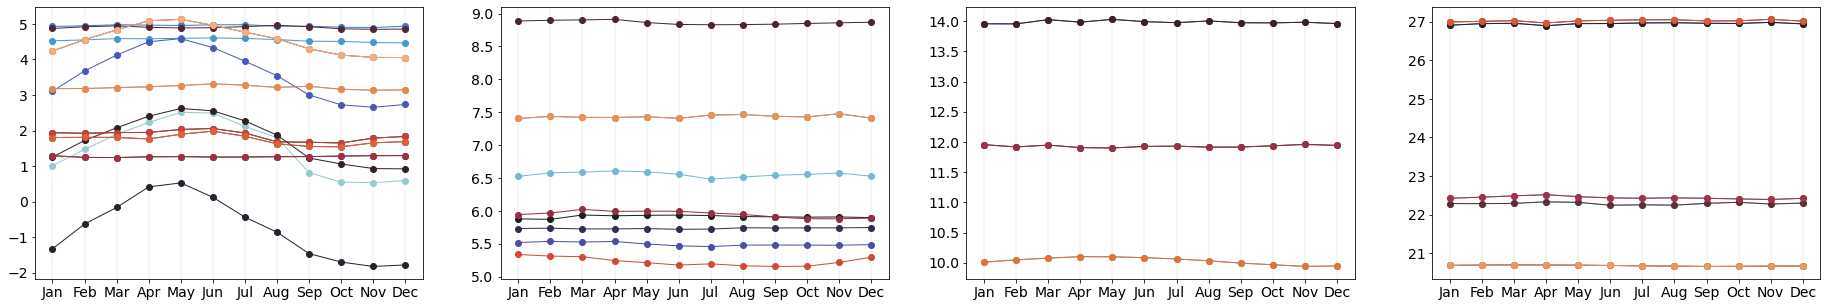

In [209]:
import calendar
fig_dir = 'figures/drought_2017to2020/borewell/'

# grouping climatologies by mean WT depth so that the seasonal variations are visible
# groups: 0 to 5 m, 5 to 10 m, 10 to 20 m, and > 20 m

datum_sel = 'DTW'

hydroids_sets = [da_clim_mean.values <= 5,
                 (da_clim_mean.values > 5) & (da_clim_mean.values <= 10),
                 (da_clim_mean.values > 10) & (da_clim_mean.values <= 20),
                 da_clim_mean.values > 20]

fig, ax = plt.subplots(nrows=1,ncols=len(hydroids_sets), figsize=(8*len(hydroids_sets),5)) #width, height

for iset in range(len(hydroids_sets)):
    data_list = [da_lt_monClim.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_lt_monClim.hydroid.values[hydroids_sets[iset]]]
    col_sel = sns.color_palette("icefire", sum(hydroids_sets[iset]))

    for xline in range(1, 13):
        ax[iset].axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
    
    for da, color in zip(data_list, col_sel):  
        ax[iset].plot(da.month.values, da.values, color=color, marker="o", linewidth=1) #, label=label)
        ax[iset].set_xlabel('')
        # if (ax_sel == 0) | (ax_sel == 7):
        #     ax[ax_sel].set_ylabel('Mean Flow (GL/month)')
        # ax.set_title(label)
        ax[iset].set_xticks(range(1,13))
        ax[iset].set_xticklabels(calendar.month_abbr[1:13])
        # plt.ylim((0, 200))
    # plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

fig.savefig(fig_dir + 'NSW_DTW_monClim_allBores_' + fig_suffix + '.png', bbox_inches='tight', dpi = 600)
fig.savefig(fig_dir + 'NSW_DTW_monClim_allBores_' + fig_suffix + '.pdf', bbox_inches='tight', format = 'pdf')

#### Using SWL in some cases
Some wells do not have DTW data, using SWL in this case

In [210]:
hydroids_noDTW = da_lt_monClim.sel(obs_point_datum = 'DTW').count('month').values == 0

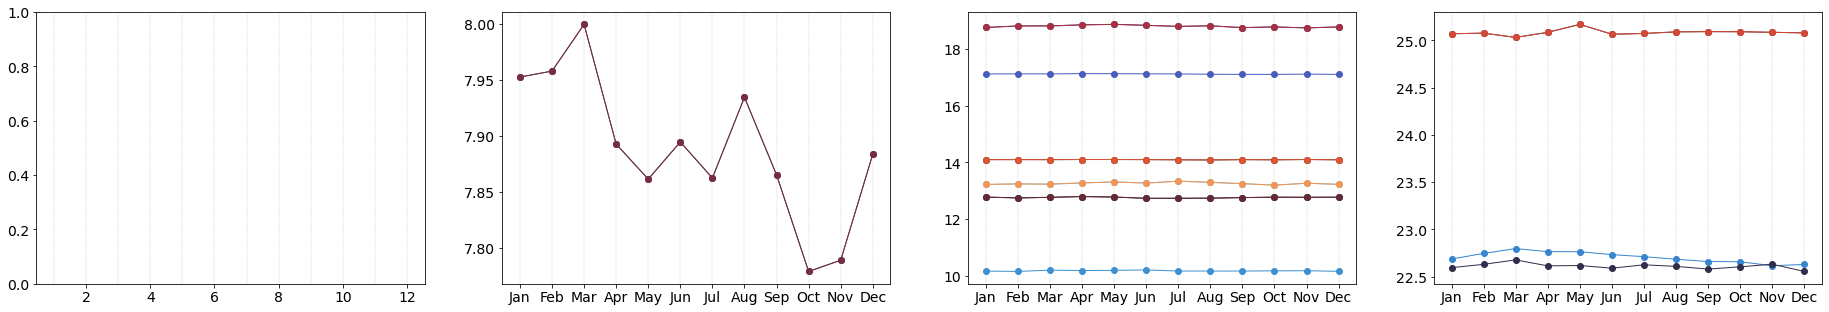

In [211]:
import calendar
fig_dir = 'figures/drought_2017to2020/borewell/'

# grouping climatologies by mean WT depth so that the seasonal variations are visible
# groups: 0 to 5 m, 5 to 10 m, 10 to 20 m, and > 20 m

datum_sel = 'SWL'

da_clim_mean_swl = da_lt_monClim.sel(obs_point_datum = datum_sel).mean('month')

hydroids_sets = [da_clim_mean_swl.values[hydroids_noDTW] <= 5,
                 (da_clim_mean_swl.values[hydroids_noDTW] > 5) & (da_clim_mean_swl.values[hydroids_noDTW] <= 10),
                 (da_clim_mean_swl.values[hydroids_noDTW] > 10) & (da_clim_mean_swl.values[hydroids_noDTW] <= 20),
                 da_clim_mean_swl.values[hydroids_noDTW] > 20]

fig, ax = plt.subplots(nrows=1,ncols=len(hydroids_sets), figsize=(8*len(hydroids_sets),5)) #width, height

for iset in range(len(hydroids_sets)):
    data_list = [da_lt_monClim.sel(hydroid = s, obs_point_datum = datum_sel) for s in da_lt_monClim.hydroid.values[hydroids_noDTW][hydroids_sets[iset]]]
    col_sel = sns.color_palette("icefire", sum(hydroids_sets[iset]))

    for xline in range(1, 13):
        ax[iset].axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
    
    for da, color in zip(data_list, col_sel):  
        ax[iset].plot(da.month.values, da.values, color=color, marker="o", linewidth=1) #, label=label)
        ax[iset].set_xlabel('')
        # if (ax_sel == 0) | (ax_sel == 7):
        #     ax[ax_sel].set_ylabel('Mean Flow (GL/month)')
        # ax.set_title(label)
        ax[iset].set_xticks(range(1,13))
        ax[iset].set_xticklabels(calendar.month_abbr[1:13])
        # plt.ylim((0, 200))
    # plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

fig.savefig(fig_dir + 'NSW_SWL_monClim_allBores_' + fig_suffix + '.png', bbox_inches='tight', dpi = 600)
fig.savefig(fig_dir + 'NSW_SWL_monClim_allBores_' + fig_suffix + '.pdf', bbox_inches='tight', format = 'pdf')

### Scratch Space

Detailed plots of data by well

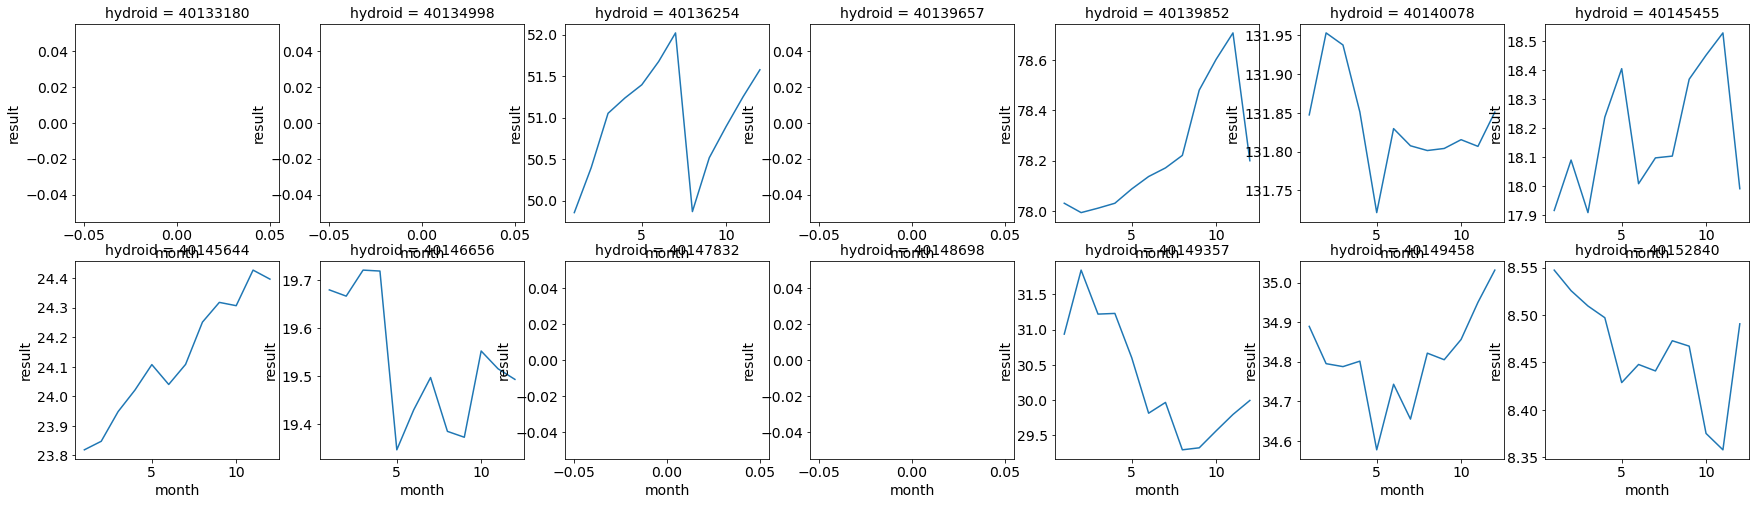

In [25]:
# QLD

fig, ax = plt.subplots(nrows=2,ncols=7, figsize=(30,8))
ax = ax.flatten()

# da_lt_zero = da_lt_monClim.where(da_lt_monClim<0)
for i in range(14):
    #da_lt_monClim[i,:,:].plot(hue = 'obs_point_datum', ax=ax[i], label=None)
    #da_lt_monClim[i,:,:].plot(hue = 'obs_point_datum', ax=ax[i], label=None)
    da_lt_monClim[i,:,:].sel(obs_point_datum = 'DTW').drop('obs_point_datum').plot(ax=ax[i], label=None)

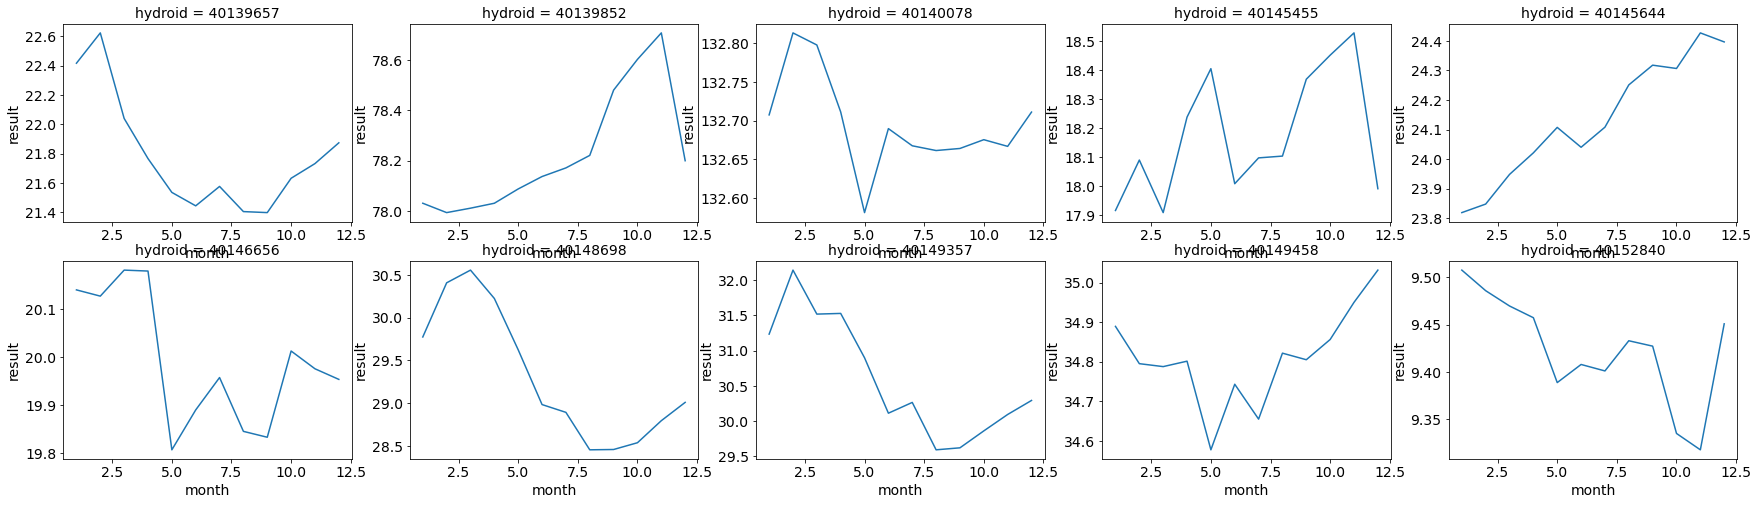

In [67]:
# QLD

fig, ax = plt.subplots(nrows=2,ncols=5, figsize=(30,8))
ax = ax.flatten()

# da_lt_zero = da_lt_monClim.where(da_lt_monClim<0)
for i in range(10):
    #da_lt_monClim[i,:,:].plot(hue = 'obs_point_datum', ax=ax[i], label=None)
    #da_lt_monClim[i,:,:].plot(hue = 'obs_point_datum', ax=ax[i], label=None)
    da_lt_monClim[i,:,:].sel(obs_point_datum = 'SWL').drop('obs_point_datum').plot(ax=ax[i], label=None)

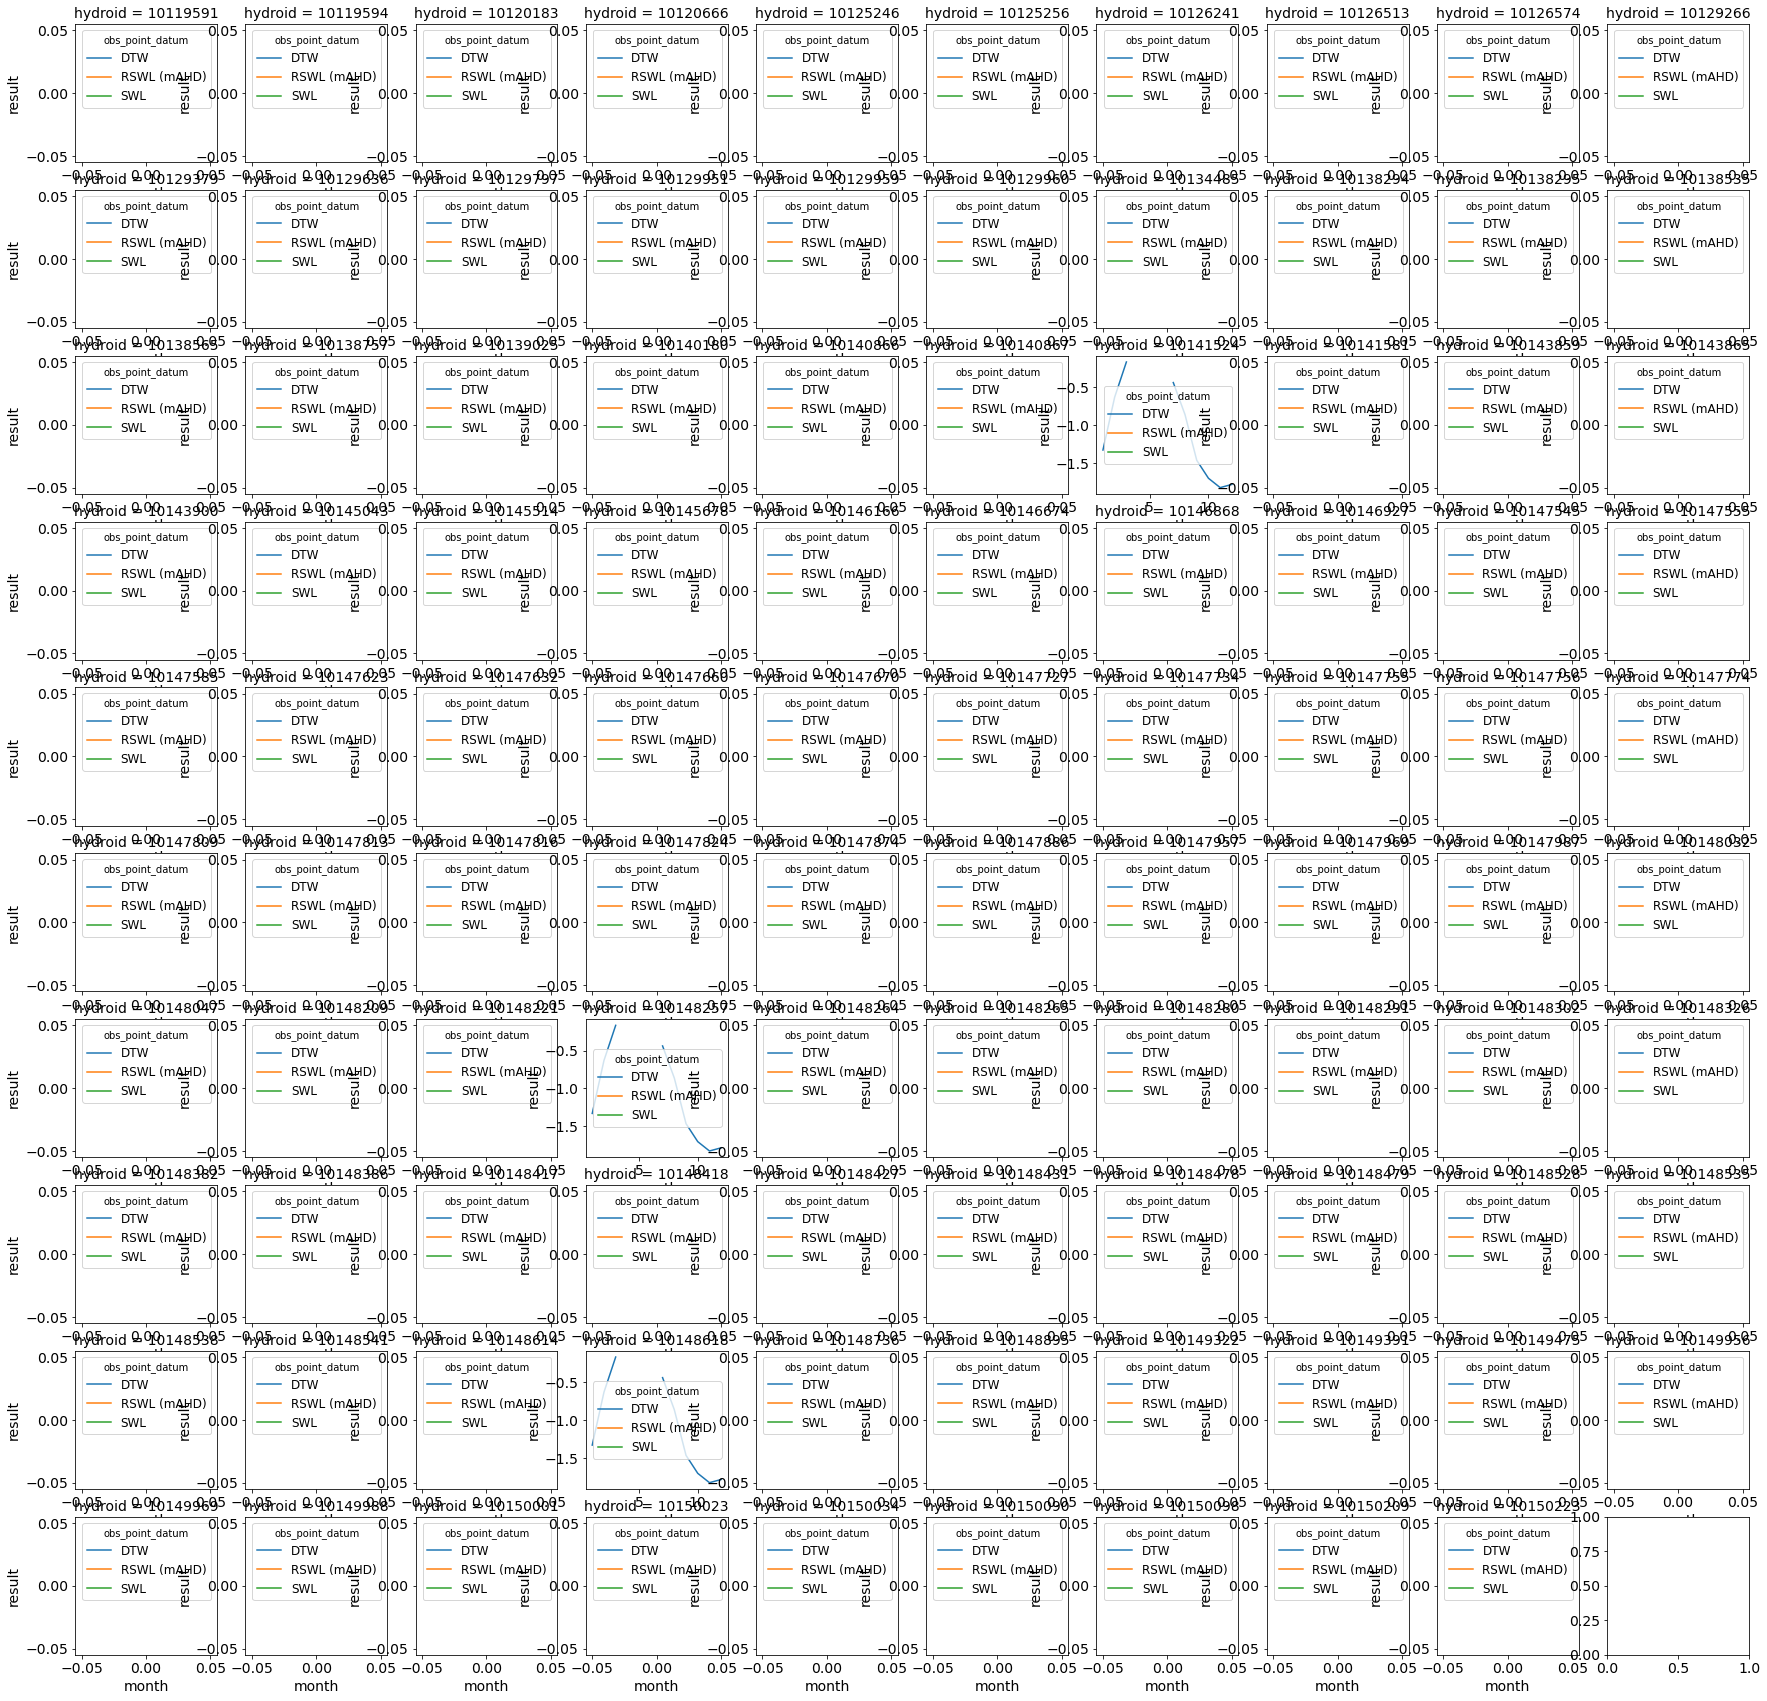

In [27]:
fig, ax = plt.subplots(nrows=10,ncols=10, figsize=(30,30))
ax = ax.flatten()

# da_lt_zero = da_lt_monClim.where(da_lt_monClim<0)
for i in range(99):
    #da_lt_monClim[i,:,:].plot(hue = 'obs_point_datum', ax=ax[i], label=None)
    da_lt_monClim.where(da_lt_monClim<0)[i,:,:].plot(hue = 'obs_point_datum', ax=ax[i], label=None)

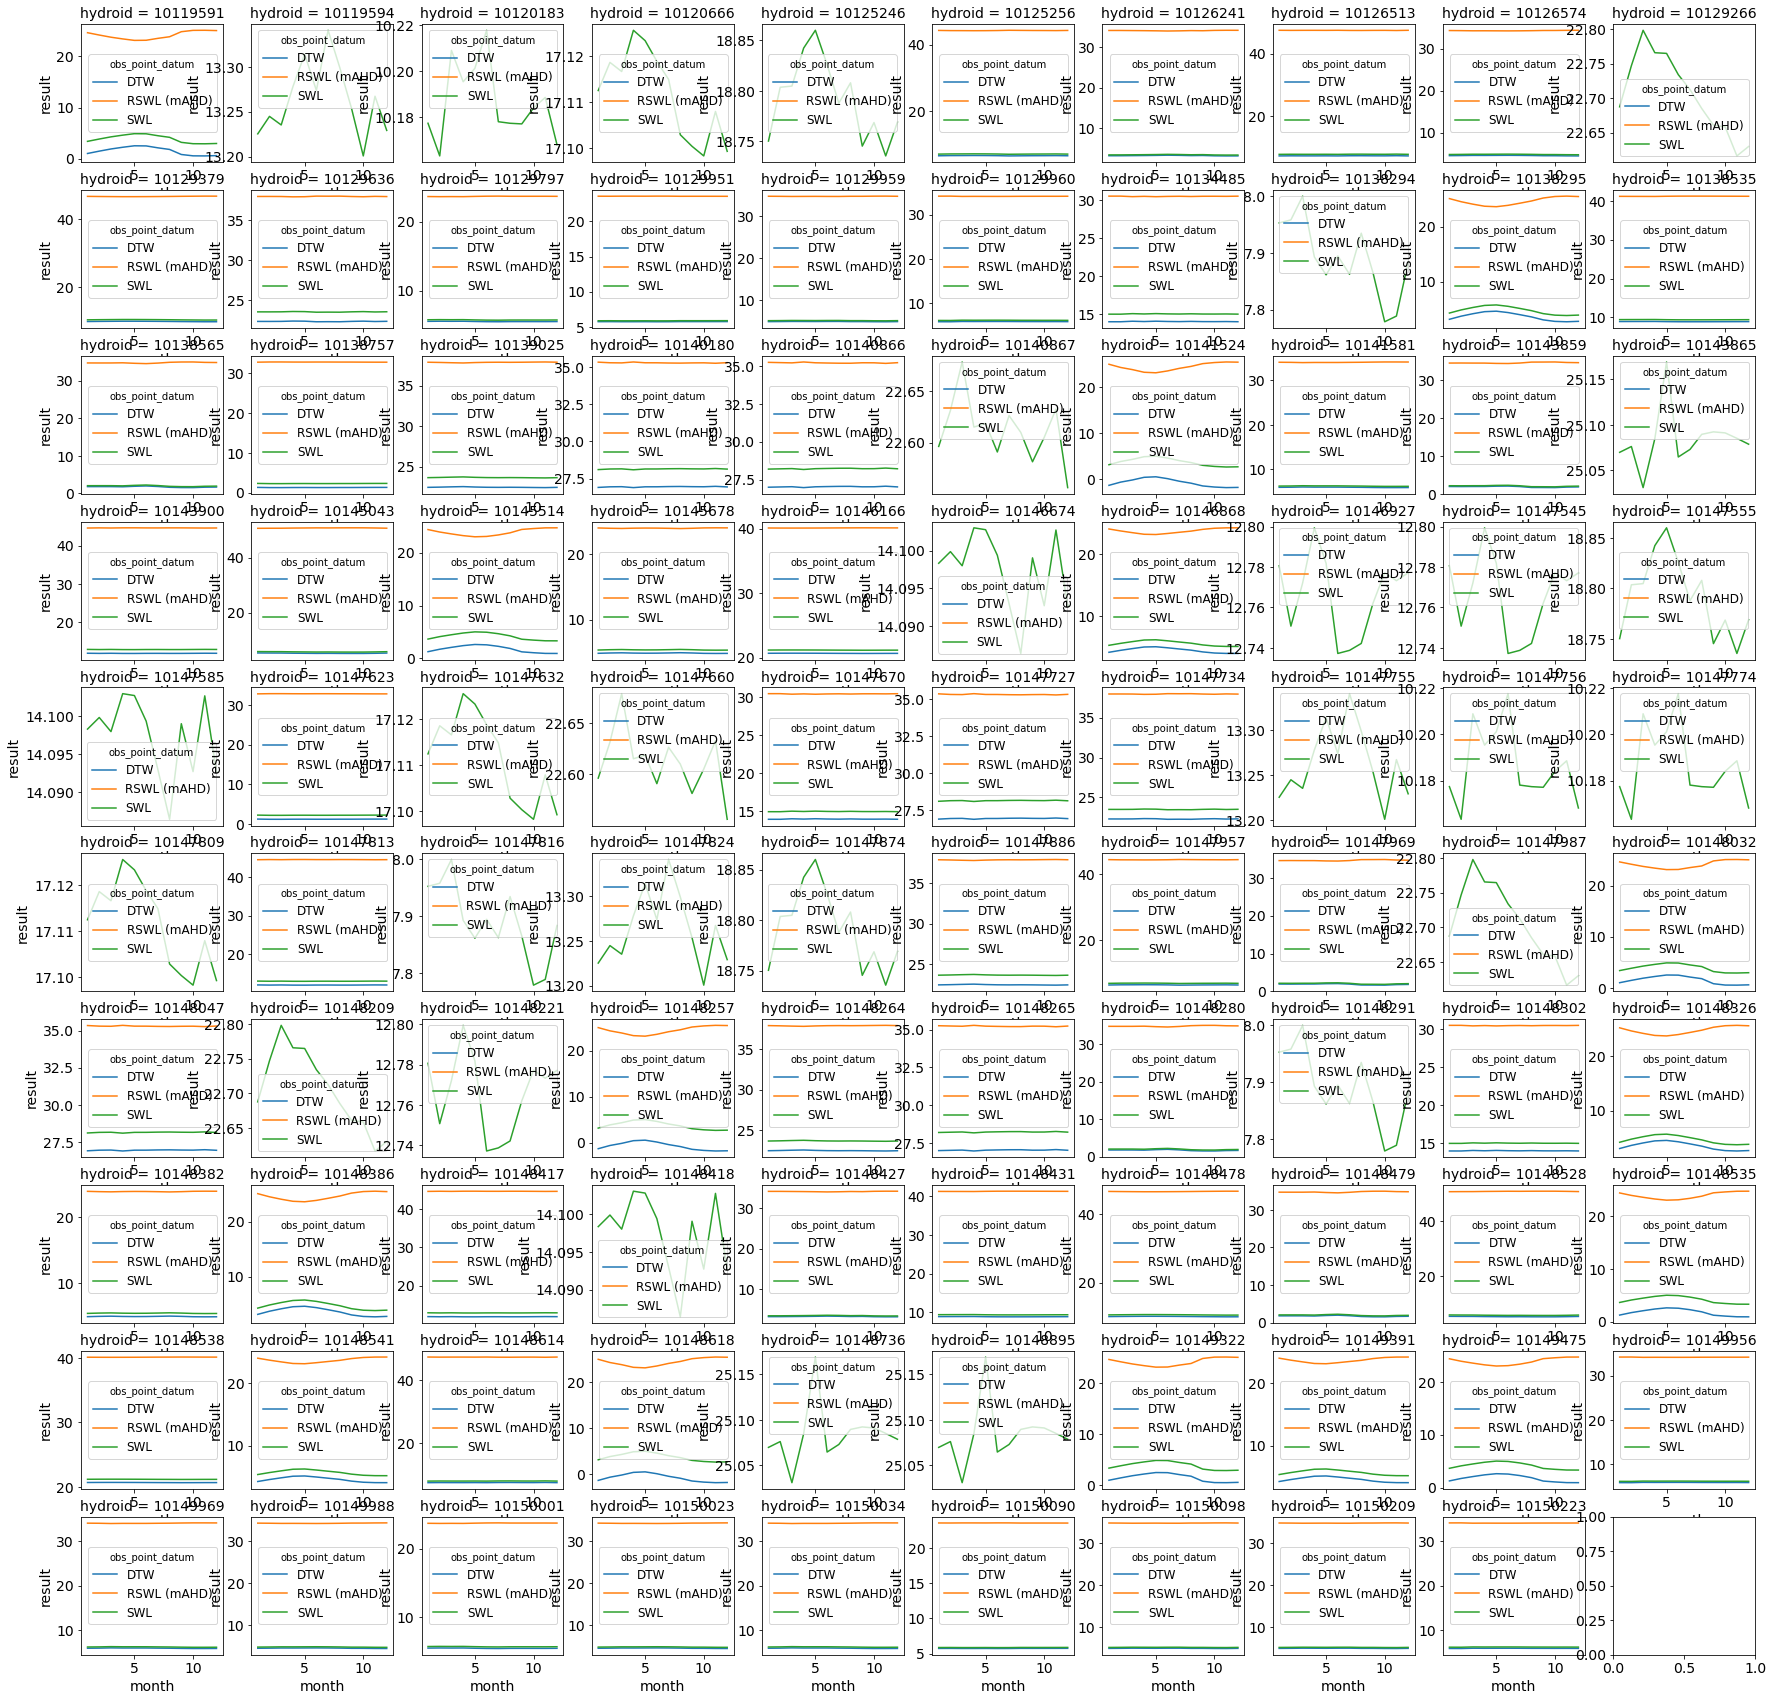

In [22]:
fig, ax = plt.subplots(nrows=10,ncols=10, figsize=(30,30))
ax = ax.flatten()
for i in range(99):
    da_lt_monClim[i,:,:].plot(hue = 'obs_point_datum', ax=ax[i], label=None)

In [12]:
da_lat = ds_gw['Latitude'].mean(['time', 'obs_point_datum'])
da_lon = ds_gw['Longitude'].mean(['time', 'obs_point_datum'])

In [16]:
out_csv_file = '/g/data/w97/ad9701/drought_2017to2020/borewell/subset_bores_NSW_post2010_latlon.csv'

df_gw_latlon = pd.DataFrame({'lat': da_lat.sel(hydroid = da_NSW_monAnom_post2010.hydroid.values).values, 
                             'lon': da_lon.sel(hydroid = da_NSW_monAnom_post2010.hydroid.values).values, 'hydroid': da_NSW_monAnom_post2010.hydroid.values})
df_gw_latlon.to_csv(out_csv_file)

In [17]:
df_gw_latlon.head()

lat         lon   hydroid
0 -34.680945  146.228662  10148352
1 -34.328428  142.366598  10140161
2 -32.048360  150.819692  10148867
3 -32.337660  150.037672  10147332
4 -32.105900  150.841500  10140165

In [18]:
da_monAnom.obs_point_datum.values

array(['DTW', 'RSWL (mAHD)', 'SWL'], dtype=object)

In [11]:
ds_gw

<xarray.Dataset>
Dimensions:          (hydroid: 376, time: 4305, obs_point_datum: 3)
Coordinates:
  * hydroid          (hydroid) int64 10119564 10119582 ... 10150255 10155122
  * time             (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2021-10-14
  * obs_point_datum  (obs_point_datum) object 'DTW' 'RSWL (mAHD)' 'SWL'
Data variables:
    result           (hydroid, time, obs_point_datum) float64 4.77 30.42 ... nan
    Longitude        (hydroid, time, obs_point_datum) float64 142.2 ... nan
    Latitude         (hydroid, time, obs_point_datum) float64 -34.17 ... nan

In [15]:
len(da_NSW_monAnom_post2010.hydroid.values)

136